In [1]:
#Import Libraries, set parametes and create model
import numpy as np
import pybamm
import matplotlib.pyplot as plt
# %matplotlib widget

pybamm.set_logging_level("NOTICE")  # To see updates after each steps of charging and discharging
# solution  = [] # blank array defined for storing solutions after simulation
params = pybamm.ParameterValues("Chen2020")    # calling parameters of chen from pybamm
params.update({"SEI kinetic rate constant [m.s-1]": 1e-15,  # updating rate const from -15to-14 for easy calculation
               "Ambient temperature [K]": 298})
spm = pybamm.lithium_ion.SPM(  # Single Particle Model (SPM) is selected with sub models given below
    {"SEI": "ec reaction limited",  # capacity fade model
        "thermal": "lumped",  # thermal model
        "SEI porosity change": "true",  # porosity change model
        "SEI film resistance": "distributed"}  # film resistance model
)


In [2]:
# Define the constants
n:int = int(input('Enter number of cycles : '))
# n_p=pulse(all cyc), n_c=C_value(each_cyc), rt=rest_time(each_cyc)
# if ">4.2V", cc-cv graph - define 2 functions and call them in if...else as fast() & pulse()
# n_p:int = int(input("Pulse number for all cycle : "))

#From what cycle onwards should updated cycle parameters take effect
rg:int = int(input("From what cycle : "))


In [3]:
# Define fuction for returning experiment cycle with user parameters

def cycle_with_params(C_value: str, rest_time: str) -> list[str]:

    cycle: list[str] = [
         f"Charge at {C_value} C for 1 minute or until 4.2 V (1 second period)",
         f"Rest for {rest_time} minutes (1 second period)"
         ]

    return cycle


In [8]:
from typing import final


# Define fuction for simulating experiment
def fast(num_cycles: int, solution_list) -> tuple[int, list]:
    '''
    Takes input number of cycles to simulate, and list of previous simulations
    returns number of entries in solution, and list of solutions
    '''
    # n_C: str = input("C value for each cycle : ")
    # rt: str = input("Rest time for each cycle : ")
    n_C: str = "2"
    rt: str = "5"
    cycle1: list[str] = ["Discharge at 5A until 2.5V"]
    cycle2: list[str] = cycle_with_params(n_C, rt)
    cycle3: list[str] = ["Charge at 15W until 4.2V", "Hold at 4.2V until 0.01A"]
    solution: list[pybamm.Solution] = solution_list
    num_entries = 0

    exp1 = pybamm.Experiment(operating_conditions=[tuple(cycle1)])
    sim1 = pybamm.Simulation(spm, experiment=exp1, parameter_values=params)
    exp2 = pybamm.Experiment(operating_conditions=[tuple(cycle2)])
    sim2 = pybamm.Simulation(spm, experiment=exp2, parameter_values=params)
    exp3 = pybamm.Experiment(operating_conditions=[tuple(cycle3)])
    sim3 = pybamm.Simulation(spm, experiment=exp3, parameter_values=params)

    # When the simulation is run for the first time, the starting_solution is not defined
    if solution == []:
        sol1 = sim1.solve()
        pulse_duration = 360 # Pluse duation is total duration of cycle (1 + 5) minutes
        while(pulse_duration == 360):
            #End time before solving
            initial_time = sol1["Time [s]"].entries[-1]
            sol1 = sim2.solve(starting_solution=sol1)
            #End time after solving
            final_time = sol1["Time [s]"].entries[-1]

            pulse_duration = final_time - initial_time
            print(pulse_duration)

        sol1 = sim3.solve(starting_solution=sol1)
        num_entries: int = len(sol1["Time [s]"].entries)
        # solving and writing results to variable sol1
        solution.append(sol1) # writing sol1 to solution array

    # n = int(input('Enter number of cycles : '))

    for i in range(num_cycles):
        sol2 = sim1.solve(starting_solution=solution[-1])
        pulse_duration = 360 # Pluse duation is total duration of cycle (1 + 5) minutes
        while(pulse_duration == 360):
            #End time before solving
            initial_time = sol2["Time [s]"].entries[-1]
            sol2 = sim2.solve(starting_solution=sol2)
            #End time after solving
            final_time = sol2["Time [s]"].entries[-1]

            pulse_duration = final_time - initial_time
            print(pulse_duration)
        sol2 = sim3.solve(starting_solution=sol2)
        solution.append(sol2)

    return num_entries, solution


In [9]:
#Define plotting function

def plot_given_range(solution, start:int, end:int, num_entries:int) -> None:
    '''
    Takes input solution, start and end cycle number, and number of entries to plot
    Plots the voltage and current for the given range of cycles
    '''
    fig, ax = plt.subplots(2, 1, figsize=(8, 8))
    solutions = solution[start:end]

    for sol in solutions:
        t = sol["Time [s]"].entries
        V = sol["Terminal voltage [V]"].entries
        I = sol["Current [A]"].entries
        ax[0].plot(t[:num_entries], V[len(V) - num_entries:])
        ax[1].plot(t[:num_entries], I[len(I) - num_entries:])

    ax[0].set_xlabel("Time [s]")
    ax[0].set_ylabel("Voltage [V]")
    ax[1].set_xlabel("Time [s]")
    ax[1].set_ylabel("Current [A]")
    ax[0].legend()
    ax[1].legend()
    plt.tight_layout()
    plt.show()


2023-06-27 07:50:49.981 - [NOTICE] logger.func(15): Cycle 1/1 (140.500 us elapsed) --------------------
2023-06-27 07:50:49.982 - [NOTICE] logger.func(15): Cycle 1/1, step 1/1: Discharge at 5A until 2.5V
2023-06-27 07:50:50.286 - [NOTICE] logger.func(15): Finish experiment simulation, took 304.813 ms
2023-06-27 07:50:50.568 - [NOTICE] logger.func(15): Cycle 2/2 (129.400 us elapsed) --------------------
2023-06-27 07:50:50.570 - [NOTICE] logger.func(15): Cycle 2/2, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:50:50.641 - [NOTICE] logger.func(15): Cycle 2/2, step 2/2: Rest for 5 minutes
2023-06-27 07:50:51.084 - [NOTICE] logger.func(15): Finish experiment simulation, took 515.868 ms
2023-06-27 07:50:51.092 - [NOTICE] logger.func(15): Cycle 3/3 (85.900 us elapsed) --------------------
2023-06-27 07:50:51.092 - [NOTICE] logger.func(15): Cycle 3/3, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:50:51.103 - [NOTICE] logger.func(15): Cycle 3/3, step 2/2

360.0


2023-06-27 07:50:51.354 - [NOTICE] logger.func(15): Finish experiment simulation, took 262.550 ms
2023-06-27 07:50:51.367 - [NOTICE] logger.func(15): Cycle 4/4 (82.800 us elapsed) --------------------
2023-06-27 07:50:51.368 - [NOTICE] logger.func(15): Cycle 4/4, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:50:51.375 - [NOTICE] logger.func(15): Cycle 4/4, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:50:52.013 - [NOTICE] logger.func(15): Finish experiment simulation, took 645.890 ms
2023-06-27 07:50:52.028 - [NOTICE] logger.func(15): Cycle 5/5 (66.400 us elapsed) --------------------
2023-06-27 07:50:52.028 - [NOTICE] logger.func(15): Cycle 5/5, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:50:52.034 - [NOTICE] logger.func(15): Cycle 5/5, step 2/2: Rest for 5 minutes
2023-06-27 07:50:52.233 - [NOTICE] logger.func(15): Finish experiment simulation, took 205.549 ms


360.0


2023-06-27 07:50:52.252 - [NOTICE] logger.func(15): Cycle 6/6 (64.100 us elapsed) --------------------
2023-06-27 07:50:52.252 - [NOTICE] logger.func(15): Cycle 6/6, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:50:52.267 - [NOTICE] logger.func(15): Cycle 6/6, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:50:52.477 - [NOTICE] logger.func(15): Finish experiment simulation, took 224.913 ms
2023-06-27 07:50:52.502 - [NOTICE] logger.func(15): Cycle 7/7 (102.100 us elapsed) --------------------
2023-06-27 07:50:52.503 - [NOTICE] logger.func(15): Cycle 7/7, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:50:52.509 - [NOTICE] logger.func(15): Cycle 7/7, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:50:52.703 - [NOTICE] logger.func(15): Finish experiment simulation, took 201.030 ms
2023-06-27 07:50:52.732 - [NOTICE] logger.func(15): Cycle 8/8 (78.400 us elapsed) --------------------
2023-06-27 07:50:52.733 - [NOTICE] logger.func(15): Cycle 8/8, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:50:52.744 - [NOTICE] logger.func(15): Cycle 8/8, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:50:52.942 - [NOTICE] logger.func(15): Finish experiment simulation, took 209.506 ms
2023-06-27 07:50:52.977 - [NOTICE] logger.func(15): Cycle 9/9 (75.800 us elapsed) --------------------
2023-06-27 07:50:52.978 - [NOTICE] logger.func(15): Cycle 9/9, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:50:52.983 - [NOTICE] logger.func(15): Cycle 9/9, step 2/2: Rest for 5 minutes
2023-06-27 07:50:53.171 - [NOTICE] logger.func(15): Finish experiment simulation, took 194.588 ms


360.0


2023-06-27 07:50:53.207 - [NOTICE] logger.func(15): Cycle 10/10 (67.900 us elapsed) --------------------
2023-06-27 07:50:53.208 - [NOTICE] logger.func(15): Cycle 10/10, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:50:53.214 - [NOTICE] logger.func(15): Cycle 10/10, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:50:53.407 - [NOTICE] logger.func(15): Finish experiment simulation, took 200.517 ms
2023-06-27 07:50:53.454 - [NOTICE] logger.func(15): Cycle 11/11 (119.500 us elapsed) --------------------
2023-06-27 07:50:53.455 - [NOTICE] logger.func(15): Cycle 11/11, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:50:53.463 - [NOTICE] logger.func(15): Cycle 11/11, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:50:53.649 - [NOTICE] logger.func(15): Finish experiment simulation, took 194.384 ms
2023-06-27 07:50:53.705 - [NOTICE] logger.func(15): Cycle 12/12 (66.500 us elapsed) --------------------
2023-06-27 07:50:53.706 - [NOTICE] logger.func(15): Cycle 12/12, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:50:53.709 - [NOTICE] logger.func(15): Cycle 12/12, step 2/2: Rest for 5 minutes
2023-06-27 07:50:53.895 - [NOTICE] logger.func(15): Finish experiment simulation, took 190.033 ms


360.0


2023-06-27 07:50:53.950 - [NOTICE] logger.func(15): Cycle 13/13 (66.300 us elapsed) --------------------
2023-06-27 07:50:53.951 - [NOTICE] logger.func(15): Cycle 13/13, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:50:53.959 - [NOTICE] logger.func(15): Cycle 13/13, step 2/2: Rest for 5 minutes
2023-06-27 07:50:54.148 - [NOTICE] logger.func(15): Finish experiment simulation, took 198.036 ms


360.0


2023-06-27 07:50:54.258 - [NOTICE] logger.func(15): Cycle 14/14 (78.800 us elapsed) --------------------
2023-06-27 07:50:54.258 - [NOTICE] logger.func(15): Cycle 14/14, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:50:54.267 - [NOTICE] logger.func(15): Cycle 14/14, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:50:54.642 - [NOTICE] logger.func(15): Finish experiment simulation, took 384.807 ms


359.9999999999991


2023-06-27 07:50:55.019 - [NOTICE] logger.func(15): Cycle 15/15 (91.600 us elapsed) --------------------
2023-06-27 07:50:55.019 - [NOTICE] logger.func(15): Cycle 15/15, step 1/2: Charge at 15W until 4.2V
2023-06-27 07:50:55.087 - [NOTICE] logger.func(15): Cycle 15/15, step 2/2: Hold at 4.2V until 0.01A
2023-06-27 07:50:55.407 - [NOTICE] logger.func(15): Finish experiment simulation, took 387.437 ms
2023-06-27 07:50:55.464 - [NOTICE] logger.func(15): Cycle 16/16 (69.000 us elapsed) --------------------
2023-06-27 07:50:55.465 - [NOTICE] logger.func(15): Cycle 16/16, step 1/1: Discharge at 5A until 2.5V
2023-06-27 07:50:55.649 - [NOTICE] logger.func(15): Finish experiment simulation, took 186.138 ms
2023-06-27 07:50:55.714 - [NOTICE] logger.func(15): Cycle 17/17 (100.800 us elapsed) --------------------
2023-06-27 07:50:55.714 - [NOTICE] logger.func(15): Cycle 17/17, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:50:55.719 - [NOTICE] logger.func(15): Cycle 17/17, step

360.0


2023-06-27 07:50:56.264 - [NOTICE] logger.func(15): Cycle 19/19 (91.900 us elapsed) --------------------
2023-06-27 07:50:56.265 - [NOTICE] logger.func(15): Cycle 19/19, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:50:56.273 - [NOTICE] logger.func(15): Cycle 19/19, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:50:56.469 - [NOTICE] logger.func(15): Finish experiment simulation, took 205.036 ms
2023-06-27 07:50:56.556 - [NOTICE] logger.func(15): Cycle 20/20 (126.600 us elapsed) --------------------
2023-06-27 07:50:56.556 - [NOTICE] logger.func(15): Cycle 20/20, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:50:56.561 - [NOTICE] logger.func(15): Cycle 20/20, step 2/2: Rest for 5 minutes
2023-06-27 07:50:56.747 - [NOTICE] logger.func(15): Finish experiment simulation, took 191.681 ms


360.0


2023-06-27 07:50:56.828 - [NOTICE] logger.func(15): Cycle 21/21 (64.900 us elapsed) --------------------
2023-06-27 07:50:56.829 - [NOTICE] logger.func(15): Cycle 21/21, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:50:56.833 - [NOTICE] logger.func(15): Cycle 21/21, step 2/2: Rest for 5 minutes
2023-06-27 07:50:57.026 - [NOTICE] logger.func(15): Finish experiment simulation, took 197.103 ms


360.0


2023-06-27 07:50:57.113 - [NOTICE] logger.func(15): Cycle 22/22 (177.700 us elapsed) --------------------
2023-06-27 07:50:57.113 - [NOTICE] logger.func(15): Cycle 22/22, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:50:57.119 - [NOTICE] logger.func(15): Cycle 22/22, step 2/2: Rest for 5 minutes
2023-06-27 07:50:57.302 - [NOTICE] logger.func(15): Finish experiment simulation, took 189.280 ms


360.0


2023-06-27 07:50:57.396 - [NOTICE] logger.func(15): Cycle 23/23 (69.500 us elapsed) --------------------
2023-06-27 07:50:57.397 - [NOTICE] logger.func(15): Cycle 23/23, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:50:57.401 - [NOTICE] logger.func(15): Cycle 23/23, step 2/2: Rest for 5 minutes
2023-06-27 07:50:57.604 - [NOTICE] logger.func(15): Finish experiment simulation, took 207.007 ms


360.0


2023-06-27 07:50:57.740 - [NOTICE] logger.func(15): Cycle 24/24 (65.200 us elapsed) --------------------
2023-06-27 07:50:57.741 - [NOTICE] logger.func(15): Cycle 24/24, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:50:57.746 - [NOTICE] logger.func(15): Cycle 24/24, step 2/2: Rest for 5 minutes
2023-06-27 07:50:57.938 - [NOTICE] logger.func(15): Finish experiment simulation, took 197.753 ms


360.0


2023-06-27 07:50:58.036 - [NOTICE] logger.func(15): Cycle 25/25 (64.500 us elapsed) --------------------
2023-06-27 07:50:58.037 - [NOTICE] logger.func(15): Cycle 25/25, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:50:58.045 - [NOTICE] logger.func(15): Cycle 25/25, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:50:58.454 - [NOTICE] logger.func(15): Finish experiment simulation, took 418.234 ms
2023-06-27 07:50:58.557 - [NOTICE] logger.func(15): Cycle 26/26 (60.800 us elapsed) --------------------
2023-06-27 07:50:58.557 - [NOTICE] logger.func(15): Cycle 26/26, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:50:58.562 - [NOTICE] logger.func(15): Cycle 26/26, step 2/2: Rest for 5 minutes
2023-06-27 07:50:58.752 - [NOTICE] logger.func(15): Finish experiment simulation, took 195.329 ms


360.0


2023-06-27 07:50:58.846 - [NOTICE] logger.func(15): Cycle 27/27 (61.900 us elapsed) --------------------
2023-06-27 07:50:58.847 - [NOTICE] logger.func(15): Cycle 27/27, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:50:58.853 - [NOTICE] logger.func(15): Cycle 27/27, step 2/2: Rest for 5 minutes
2023-06-27 07:50:59.046 - [NOTICE] logger.func(15): Finish experiment simulation, took 199.724 ms


360.0


2023-06-27 07:50:59.156 - [NOTICE] logger.func(15): Cycle 28/28 (68.000 us elapsed) --------------------
2023-06-27 07:50:59.156 - [NOTICE] logger.func(15): Cycle 28/28, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:50:59.160 - [NOTICE] logger.func(15): Cycle 28/28, step 2/2: Rest for 5 minutes
2023-06-27 07:50:59.341 - [NOTICE] logger.func(15): Finish experiment simulation, took 185.239 ms


360.0


2023-06-27 07:50:59.459 - [NOTICE] logger.func(15): Cycle 29/29 (63.900 us elapsed) --------------------
2023-06-27 07:50:59.459 - [NOTICE] logger.func(15): Cycle 29/29, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:50:59.464 - [NOTICE] logger.func(15): Cycle 29/29, step 2/2: Rest for 5 minutes
2023-06-27 07:50:59.656 - [NOTICE] logger.func(15): Finish experiment simulation, took 196.016 ms


360.0


2023-06-27 07:50:59.774 - [NOTICE] logger.func(15): Cycle 30/30 (63.200 us elapsed) --------------------
2023-06-27 07:50:59.775 - [NOTICE] logger.func(15): Cycle 30/30, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:50:59.779 - [NOTICE] logger.func(15): Cycle 30/30, step 2/2: Rest for 5 minutes
2023-06-27 07:50:59.968 - [NOTICE] logger.func(15): Finish experiment simulation, took 193.787 ms


360.0


2023-06-27 07:51:00.092 - [NOTICE] logger.func(15): Cycle 31/31 (66.800 us elapsed) --------------------
2023-06-27 07:51:00.093 - [NOTICE] logger.func(15): Cycle 31/31, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:00.097 - [NOTICE] logger.func(15): Cycle 31/31, step 2/2: Rest for 5 minutes
2023-06-27 07:51:00.276 - [NOTICE] logger.func(15): Finish experiment simulation, took 183.549 ms


360.0


2023-06-27 07:51:00.489 - [NOTICE] logger.func(15): Cycle 32/32 (113.400 us elapsed) --------------------
2023-06-27 07:51:00.489 - [NOTICE] logger.func(15): Cycle 32/32, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:00.493 - [NOTICE] logger.func(15): Cycle 32/32, step 2/2: Rest for 5 minutes
2023-06-27 07:51:00.673 - [NOTICE] logger.func(15): Finish experiment simulation, took 184.277 ms


360.0


2023-06-27 07:51:00.798 - [NOTICE] logger.func(15): Cycle 33/33 (102.100 us elapsed) --------------------
2023-06-27 07:51:00.799 - [NOTICE] logger.func(15): Cycle 33/33, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:00.804 - [NOTICE] logger.func(15): Cycle 33/33, step 2/2: Rest for 5 minutes
2023-06-27 07:51:01.004 - [NOTICE] logger.func(15): Finish experiment simulation, took 205.407 ms


360.0


2023-06-27 07:51:01.137 - [NOTICE] logger.func(15): Cycle 34/34 (66.600 us elapsed) --------------------
2023-06-27 07:51:01.138 - [NOTICE] logger.func(15): Cycle 34/34, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:01.143 - [NOTICE] logger.func(15): Cycle 34/34, step 2/2: Rest for 5 minutes
2023-06-27 07:51:01.326 - [NOTICE] logger.func(15): Finish experiment simulation, took 188.265 ms


360.0


2023-06-27 07:51:01.469 - [NOTICE] logger.func(15): Cycle 35/35 (67.900 us elapsed) --------------------
2023-06-27 07:51:01.469 - [NOTICE] logger.func(15): Cycle 35/35, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:01.475 - [NOTICE] logger.func(15): Cycle 35/35, step 2/2: Rest for 5 minutes
2023-06-27 07:51:01.665 - [NOTICE] logger.func(15): Finish experiment simulation, took 196.074 ms


360.0


2023-06-27 07:51:01.811 - [NOTICE] logger.func(15): Cycle 36/36 (77.400 us elapsed) --------------------
2023-06-27 07:51:01.811 - [NOTICE] logger.func(15): Cycle 36/36, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:01.816 - [NOTICE] logger.func(15): Cycle 36/36, step 2/2: Rest for 5 minutes
2023-06-27 07:51:02.012 - [NOTICE] logger.func(15): Finish experiment simulation, took 200.857 ms


360.0


2023-06-27 07:51:02.210 - [NOTICE] logger.func(15): Cycle 37/37 (70.000 us elapsed) --------------------
2023-06-27 07:51:02.210 - [NOTICE] logger.func(15): Cycle 37/37, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:02.214 - [NOTICE] logger.func(15): Cycle 37/37, step 2/2: Rest for 5 minutes
2023-06-27 07:51:02.398 - [NOTICE] logger.func(15): Finish experiment simulation, took 188.325 ms


360.0


2023-06-27 07:51:02.548 - [NOTICE] logger.func(15): Cycle 38/38 (89.000 us elapsed) --------------------
2023-06-27 07:51:02.549 - [NOTICE] logger.func(15): Cycle 38/38, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:02.557 - [NOTICE] logger.func(15): Cycle 38/38, step 2/2: Rest for 5 minutes
2023-06-27 07:51:02.742 - [NOTICE] logger.func(15): Finish experiment simulation, took 192.907 ms


360.0


2023-06-27 07:51:02.897 - [NOTICE] logger.func(15): Cycle 39/39 (67.900 us elapsed) --------------------
2023-06-27 07:51:02.897 - [NOTICE] logger.func(15): Cycle 39/39, step 1/2: Charge at 15W until 4.2V
2023-06-27 07:51:02.910 - [NOTICE] logger.func(15): Cycle 39/39, step 2/2: Hold at 4.2V until 0.01A


342.19986304527265


2023-06-27 07:51:03.331 - [NOTICE] logger.func(15): Finish experiment simulation, took 433.628 ms
2023-06-27 07:51:03.333 - [NOTICE] logger.func(15): Cycle 40/40 (72.000 us elapsed) --------------------
2023-06-27 07:51:03.334 - [NOTICE] logger.func(15): Cycle 40/40, step 1/1: Discharge at 5A until 2.5V
2023-06-27 07:51:03.532 - [NOTICE] logger.func(15): Finish experiment simulation, took 197.816 ms
2023-06-27 07:51:03.695 - [NOTICE] logger.func(15): Cycle 41/41 (72.700 us elapsed) --------------------
2023-06-27 07:51:03.696 - [NOTICE] logger.func(15): Cycle 41/41, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:03.702 - [NOTICE] logger.func(15): Cycle 41/41, step 2/2: Rest for 5 minutes
2023-06-27 07:51:03.888 - [NOTICE] logger.func(15): Finish experiment simulation, took 191.638 ms
2023-06-27 07:51:04.039 - [NOTICE] logger.func(15): Cycle 42/42 (64.800 us elapsed) --------------------
2023-06-27 07:51:04.039 - [NOTICE] logger.func(15): Cycle 42/42, step 1/2: Cha

360.0


2023-06-27 07:51:04.391 - [NOTICE] logger.func(15): Cycle 43/43 (66.400 us elapsed) --------------------
2023-06-27 07:51:04.392 - [NOTICE] logger.func(15): Cycle 43/43, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:04.397 - [NOTICE] logger.func(15): Cycle 43/43, step 2/2: Rest for 5 minutes
2023-06-27 07:51:04.593 - [NOTICE] logger.func(15): Finish experiment simulation, took 202.504 ms


360.0


2023-06-27 07:51:04.768 - [NOTICE] logger.func(15): Cycle 44/44 (209.400 us elapsed) --------------------
2023-06-27 07:51:04.769 - [NOTICE] logger.func(15): Cycle 44/44, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:04.774 - [NOTICE] logger.func(15): Cycle 44/44, step 2/2: Rest for 5 minutes
2023-06-27 07:51:04.969 - [NOTICE] logger.func(15): Finish experiment simulation, took 200.502 ms


360.0


2023-06-27 07:51:05.141 - [NOTICE] logger.func(15): Cycle 45/45 (65.500 us elapsed) --------------------
2023-06-27 07:51:05.142 - [NOTICE] logger.func(15): Cycle 45/45, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:05.147 - [NOTICE] logger.func(15): Cycle 45/45, step 2/2: Rest for 5 minutes
2023-06-27 07:51:05.343 - [NOTICE] logger.func(15): Finish experiment simulation, took 200.647 ms


360.0


2023-06-27 07:51:05.525 - [NOTICE] logger.func(15): Cycle 46/46 (227.700 us elapsed) --------------------
2023-06-27 07:51:05.526 - [NOTICE] logger.func(15): Cycle 46/46, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:05.531 - [NOTICE] logger.func(15): Cycle 46/46, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:51:05.759 - [NOTICE] logger.func(15): Finish experiment simulation, took 234.341 ms
2023-06-27 07:51:05.938 - [NOTICE] logger.func(15): Cycle 47/47 (63.900 us elapsed) --------------------
2023-06-27 07:51:05.938 - [NOTICE] logger.func(15): Cycle 47/47, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:05.944 - [NOTICE] logger.func(15): Cycle 47/47, step 2/2: Rest for 5 minutes
2023-06-27 07:51:06.140 - [NOTICE] logger.func(15): Finish experiment simulation, took 202.242 ms


360.0


2023-06-27 07:51:06.331 - [NOTICE] logger.func(15): Cycle 48/48 (67.900 us elapsed) --------------------
2023-06-27 07:51:06.331 - [NOTICE] logger.func(15): Cycle 48/48, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:06.336 - [NOTICE] logger.func(15): Cycle 48/48, step 2/2: Rest for 5 minutes
2023-06-27 07:51:06.527 - [NOTICE] logger.func(15): Finish experiment simulation, took 195.167 ms


360.0


2023-06-27 07:51:06.712 - [NOTICE] logger.func(15): Cycle 49/49 (107.700 us elapsed) --------------------
2023-06-27 07:51:06.713 - [NOTICE] logger.func(15): Cycle 49/49, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:06.717 - [NOTICE] logger.func(15): Cycle 49/49, step 2/2: Rest for 5 minutes
2023-06-27 07:51:06.903 - [NOTICE] logger.func(15): Finish experiment simulation, took 190.920 ms


360.0


2023-06-27 07:51:07.094 - [NOTICE] logger.func(15): Cycle 50/50 (65.700 us elapsed) --------------------
2023-06-27 07:51:07.095 - [NOTICE] logger.func(15): Cycle 50/50, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:07.099 - [NOTICE] logger.func(15): Cycle 50/50, step 2/2: Rest for 5 minutes
2023-06-27 07:51:07.296 - [NOTICE] logger.func(15): Finish experiment simulation, took 201.594 ms


360.0


2023-06-27 07:51:07.491 - [NOTICE] logger.func(15): Cycle 51/51 (68.900 us elapsed) --------------------
2023-06-27 07:51:07.492 - [NOTICE] logger.func(15): Cycle 51/51, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:07.497 - [NOTICE] logger.func(15): Cycle 51/51, step 2/2: Rest for 5 minutes
2023-06-27 07:51:07.692 - [NOTICE] logger.func(15): Finish experiment simulation, took 200.430 ms


360.0


2023-06-27 07:51:07.894 - [NOTICE] logger.func(15): Cycle 52/52 (68.200 us elapsed) --------------------
2023-06-27 07:51:07.895 - [NOTICE] logger.func(15): Cycle 52/52, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:07.900 - [NOTICE] logger.func(15): Cycle 52/52, step 2/2: Rest for 5 minutes
2023-06-27 07:51:08.088 - [NOTICE] logger.func(15): Finish experiment simulation, took 192.752 ms


360.0


2023-06-27 07:51:08.292 - [NOTICE] logger.func(15): Cycle 53/53 (74.400 us elapsed) --------------------
2023-06-27 07:51:08.294 - [NOTICE] logger.func(15): Cycle 53/53, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:08.298 - [NOTICE] logger.func(15): Cycle 53/53, step 2/2: Rest for 5 minutes
2023-06-27 07:51:08.489 - [NOTICE] logger.func(15): Finish experiment simulation, took 195.600 ms


360.0


2023-06-27 07:51:08.755 - [NOTICE] logger.func(15): Cycle 54/54 (66.100 us elapsed) --------------------
2023-06-27 07:51:08.756 - [NOTICE] logger.func(15): Cycle 54/54, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:08.761 - [NOTICE] logger.func(15): Cycle 54/54, step 2/2: Rest for 5 minutes
2023-06-27 07:51:08.943 - [NOTICE] logger.func(15): Finish experiment simulation, took 187.429 ms


360.0


2023-06-27 07:51:09.186 - [NOTICE] logger.func(15): Cycle 55/55 (64.600 us elapsed) --------------------
2023-06-27 07:51:09.186 - [NOTICE] logger.func(15): Cycle 55/55, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:09.191 - [NOTICE] logger.func(15): Cycle 55/55, step 2/2: Rest for 5 minutes
2023-06-27 07:51:09.389 - [NOTICE] logger.func(15): Finish experiment simulation, took 202.571 ms


360.0


2023-06-27 07:51:09.601 - [NOTICE] logger.func(15): Cycle 56/56 (67.800 us elapsed) --------------------
2023-06-27 07:51:09.602 - [NOTICE] logger.func(15): Cycle 56/56, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:09.608 - [NOTICE] logger.func(15): Cycle 56/56, step 2/2: Rest for 5 minutes
2023-06-27 07:51:09.797 - [NOTICE] logger.func(15): Finish experiment simulation, took 195.216 ms


360.0


2023-06-27 07:51:10.017 - [NOTICE] logger.func(15): Cycle 57/57 (105.800 us elapsed) --------------------
2023-06-27 07:51:10.017 - [NOTICE] logger.func(15): Cycle 57/57, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:10.023 - [NOTICE] logger.func(15): Cycle 57/57, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:51:10.491 - [NOTICE] logger.func(15): Finish experiment simulation, took 472.852 ms
2023-06-27 07:51:10.703 - [NOTICE] logger.func(15): Cycle 58/58 (106.300 us elapsed) --------------------
2023-06-27 07:51:10.703 - [NOTICE] logger.func(15): Cycle 58/58, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:10.709 - [NOTICE] logger.func(15): Cycle 58/58, step 2/2: Rest for 5 minutes
2023-06-27 07:51:10.898 - [NOTICE] logger.func(15): Finish experiment simulation, took 194.365 ms


360.0


2023-06-27 07:51:11.120 - [NOTICE] logger.func(15): Cycle 59/59 (64.000 us elapsed) --------------------
2023-06-27 07:51:11.121 - [NOTICE] logger.func(15): Cycle 59/59, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:11.126 - [NOTICE] logger.func(15): Cycle 59/59, step 2/2: Rest for 5 minutes
2023-06-27 07:51:11.312 - [NOTICE] logger.func(15): Finish experiment simulation, took 190.890 ms


360.0


2023-06-27 07:51:11.543 - [NOTICE] logger.func(15): Cycle 60/60 (65.300 us elapsed) --------------------
2023-06-27 07:51:11.544 - [NOTICE] logger.func(15): Cycle 60/60, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:11.549 - [NOTICE] logger.func(15): Cycle 60/60, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:51:11.745 - [NOTICE] logger.func(15): Finish experiment simulation, took 201.008 ms
2023-06-27 07:51:12.018 - [NOTICE] logger.func(15): Cycle 61/61 (105.900 us elapsed) --------------------
2023-06-27 07:51:12.019 - [NOTICE] logger.func(15): Cycle 61/61, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:12.023 - [NOTICE] logger.func(15): Cycle 61/61, step 2/2: Rest for 5 minutes
2023-06-27 07:51:12.204 - [NOTICE] logger.func(15): Finish experiment simulation, took 184.776 ms


360.0


2023-06-27 07:51:12.450 - [NOTICE] logger.func(15): Cycle 62/62 (103.600 us elapsed) --------------------
2023-06-27 07:51:12.451 - [NOTICE] logger.func(15): Cycle 62/62, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:12.458 - [NOTICE] logger.func(15): Cycle 62/62, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:51:12.654 - [NOTICE] logger.func(15): Finish experiment simulation, took 203.832 ms
2023-06-27 07:51:12.903 - [NOTICE] logger.func(15): Cycle 63/63 (76.500 us elapsed) --------------------
2023-06-27 07:51:12.904 - [NOTICE] logger.func(15): Cycle 63/63, step 1/2: Charge at 15W until 4.2V
2023-06-27 07:51:12.919 - [NOTICE] logger.func(15): Cycle 63/63, step 2/2: Hold at 4.2V until 0.01A


341.2579385860299


2023-06-27 07:51:13.129 - [NOTICE] logger.func(15): Finish experiment simulation, took 223.424 ms
2023-06-27 07:51:13.130 - [NOTICE] logger.func(15): Cycle 64/64 (100.300 us elapsed) --------------------
2023-06-27 07:51:13.131 - [NOTICE] logger.func(15): Cycle 64/64, step 1/1: Discharge at 5A until 2.5V
2023-06-27 07:51:13.330 - [NOTICE] logger.func(15): Finish experiment simulation, took 198.386 ms
2023-06-27 07:51:13.566 - [NOTICE] logger.func(15): Cycle 65/65 (69.300 us elapsed) --------------------
2023-06-27 07:51:13.566 - [NOTICE] logger.func(15): Cycle 65/65, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:13.571 - [NOTICE] logger.func(15): Cycle 65/65, step 2/2: Rest for 5 minutes
2023-06-27 07:51:13.756 - [NOTICE] logger.func(15): Finish experiment simulation, took 189.595 ms
2023-06-27 07:51:13.996 - [NOTICE] logger.func(15): Cycle 66/66 (71.400 us elapsed) --------------------
2023-06-27 07:51:13.996 - [NOTICE] logger.func(15): Cycle 66/66, step 1/2: Ch

360.0


2023-06-27 07:51:14.438 - [NOTICE] logger.func(15): Cycle 67/67 (76.400 us elapsed) --------------------
2023-06-27 07:51:14.439 - [NOTICE] logger.func(15): Cycle 67/67, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:14.443 - [NOTICE] logger.func(15): Cycle 67/67, step 2/2: Rest for 5 minutes
2023-06-27 07:51:14.636 - [NOTICE] logger.func(15): Finish experiment simulation, took 197.967 ms


360.0


2023-06-27 07:51:14.904 - [NOTICE] logger.func(15): Cycle 68/68 (72.700 us elapsed) --------------------
2023-06-27 07:51:14.905 - [NOTICE] logger.func(15): Cycle 68/68, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:14.910 - [NOTICE] logger.func(15): Cycle 68/68, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:51:15.104 - [NOTICE] logger.func(15): Finish experiment simulation, took 198.871 ms
2023-06-27 07:51:15.362 - [NOTICE] logger.func(15): Cycle 69/69 (79.000 us elapsed) --------------------
2023-06-27 07:51:15.363 - [NOTICE] logger.func(15): Cycle 69/69, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:15.367 - [NOTICE] logger.func(15): Cycle 69/69, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:51:15.549 - [NOTICE] logger.func(15): Finish experiment simulation, took 186.165 ms
2023-06-27 07:51:15.815 - [NOTICE] logger.func(15): Cycle 70/70 (69.500 us elapsed) --------------------
2023-06-27 07:51:15.815 - [NOTICE] logger.func(15): Cycle 70/70, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:15.820 - [NOTICE] logger.func(15): Cycle 70/70, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:51:16.067 - [NOTICE] logger.func(15): Finish experiment simulation, took 251.450 ms
2023-06-27 07:51:16.328 - [NOTICE] logger.func(15): Cycle 71/71 (66.800 us elapsed) --------------------
2023-06-27 07:51:16.328 - [NOTICE] logger.func(15): Cycle 71/71, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:16.334 - [NOTICE] logger.func(15): Cycle 71/71, step 2/2: Rest for 5 minutes
2023-06-27 07:51:16.528 - [NOTICE] logger.func(15): Finish experiment simulation, took 199.351 ms


360.0


2023-06-27 07:51:16.802 - [NOTICE] logger.func(15): Cycle 72/72 (70.400 us elapsed) --------------------
2023-06-27 07:51:16.803 - [NOTICE] logger.func(15): Cycle 72/72, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:16.808 - [NOTICE] logger.func(15): Cycle 72/72, step 2/2: Rest for 5 minutes
2023-06-27 07:51:16.999 - [NOTICE] logger.func(15): Finish experiment simulation, took 195.904 ms


360.0


2023-06-27 07:51:17.275 - [NOTICE] logger.func(15): Cycle 73/73 (68.300 us elapsed) --------------------
2023-06-27 07:51:17.276 - [NOTICE] logger.func(15): Cycle 73/73, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:17.280 - [NOTICE] logger.func(15): Cycle 73/73, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:51:17.521 - [NOTICE] logger.func(15): Finish experiment simulation, took 243.315 ms
2023-06-27 07:51:17.799 - [NOTICE] logger.func(15): Cycle 74/74 (79.800 us elapsed) --------------------
2023-06-27 07:51:17.800 - [NOTICE] logger.func(15): Cycle 74/74, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:17.805 - [NOTICE] logger.func(15): Cycle 74/74, step 2/2: Rest for 5 minutes
2023-06-27 07:51:17.993 - [NOTICE] logger.func(15): Finish experiment simulation, took 192.123 ms


360.0


2023-06-27 07:51:18.280 - [NOTICE] logger.func(15): Cycle 75/75 (68.100 us elapsed) --------------------
2023-06-27 07:51:18.280 - [NOTICE] logger.func(15): Cycle 75/75, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:18.285 - [NOTICE] logger.func(15): Cycle 75/75, step 2/2: Rest for 5 minutes
2023-06-27 07:51:18.487 - [NOTICE] logger.func(15): Finish experiment simulation, took 206.726 ms


360.0


2023-06-27 07:51:18.776 - [NOTICE] logger.func(15): Cycle 76/76 (77.000 us elapsed) --------------------
2023-06-27 07:51:18.776 - [NOTICE] logger.func(15): Cycle 76/76, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:18.780 - [NOTICE] logger.func(15): Cycle 76/76, step 2/2: Rest for 5 minutes
2023-06-27 07:51:18.971 - [NOTICE] logger.func(15): Finish experiment simulation, took 194.856 ms


360.0


2023-06-27 07:51:19.260 - [NOTICE] logger.func(15): Cycle 77/77 (102.500 us elapsed) --------------------
2023-06-27 07:51:19.261 - [NOTICE] logger.func(15): Cycle 77/77, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:19.265 - [NOTICE] logger.func(15): Cycle 77/77, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:51:19.730 - [NOTICE] logger.func(15): Finish experiment simulation, took 469.208 ms
2023-06-27 07:51:20.085 - [NOTICE] logger.func(15): Cycle 78/78 (69.400 us elapsed) --------------------
2023-06-27 07:51:20.087 - [NOTICE] logger.func(15): Cycle 78/78, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:20.091 - [NOTICE] logger.func(15): Cycle 78/78, step 2/2: Rest for 5 minutes
2023-06-27 07:51:20.274 - [NOTICE] logger.func(15): Finish experiment simulation, took 187.107 ms


360.0


2023-06-27 07:51:20.584 - [NOTICE] logger.func(15): Cycle 79/79 (68.400 us elapsed) --------------------
2023-06-27 07:51:20.585 - [NOTICE] logger.func(15): Cycle 79/79, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:20.590 - [NOTICE] logger.func(15): Cycle 79/79, step 2/2: Rest for 5 minutes
2023-06-27 07:51:20.787 - [NOTICE] logger.func(15): Finish experiment simulation, took 201.042 ms


360.0


2023-06-27 07:51:21.116 - [NOTICE] logger.func(15): Cycle 80/80 (71.200 us elapsed) --------------------
2023-06-27 07:51:21.116 - [NOTICE] logger.func(15): Cycle 80/80, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:21.121 - [NOTICE] logger.func(15): Cycle 80/80, step 2/2: Rest for 5 minutes
2023-06-27 07:51:21.315 - [NOTICE] logger.func(15): Finish experiment simulation, took 198.742 ms


360.0


2023-06-27 07:51:21.629 - [NOTICE] logger.func(15): Cycle 81/81 (69.700 us elapsed) --------------------
2023-06-27 07:51:21.629 - [NOTICE] logger.func(15): Cycle 81/81, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:21.634 - [NOTICE] logger.func(15): Cycle 81/81, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:51:21.830 - [NOTICE] logger.func(15): Finish experiment simulation, took 200.120 ms
2023-06-27 07:51:22.147 - [NOTICE] logger.func(15): Cycle 82/82 (103.700 us elapsed) --------------------
2023-06-27 07:51:22.148 - [NOTICE] logger.func(15): Cycle 82/82, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:22.152 - [NOTICE] logger.func(15): Cycle 82/82, step 2/2: Rest for 5 minutes
2023-06-27 07:51:22.342 - [NOTICE] logger.func(15): Finish experiment simulation, took 193.907 ms


360.0


2023-06-27 07:51:22.663 - [NOTICE] logger.func(15): Cycle 83/83 (72.600 us elapsed) --------------------
2023-06-27 07:51:22.664 - [NOTICE] logger.func(15): Cycle 83/83, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:22.668 - [NOTICE] logger.func(15): Cycle 83/83, step 2/2: Rest for 5 minutes
2023-06-27 07:51:22.855 - [NOTICE] logger.func(15): Finish experiment simulation, took 190.523 ms


360.0


2023-06-27 07:51:23.184 - [NOTICE] logger.func(15): Cycle 84/84 (72.300 us elapsed) --------------------
2023-06-27 07:51:23.184 - [NOTICE] logger.func(15): Cycle 84/84, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:23.190 - [NOTICE] logger.func(15): Cycle 84/84, step 2/2: Rest for 5 minutes
2023-06-27 07:51:23.372 - [NOTICE] logger.func(15): Finish experiment simulation, took 186.807 ms


360.0


2023-06-27 07:51:23.703 - [NOTICE] logger.func(15): Cycle 85/85 (112.400 us elapsed) --------------------
2023-06-27 07:51:23.703 - [NOTICE] logger.func(15): Cycle 85/85, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:23.708 - [NOTICE] logger.func(15): Cycle 85/85, step 2/2: Rest for 5 minutes
2023-06-27 07:51:23.896 - [NOTICE] logger.func(15): Finish experiment simulation, took 192.869 ms


360.0


2023-06-27 07:51:24.291 - [NOTICE] logger.func(15): Cycle 86/86 (76.300 us elapsed) --------------------
2023-06-27 07:51:24.292 - [NOTICE] logger.func(15): Cycle 86/86, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:24.299 - [NOTICE] logger.func(15): Cycle 86/86, step 2/2: Rest for 5 minutes
2023-06-27 07:51:24.488 - [NOTICE] logger.func(15): Finish experiment simulation, took 195.784 ms


360.0


2023-06-27 07:51:24.824 - [NOTICE] logger.func(15): Cycle 87/87 (74.400 us elapsed) --------------------
2023-06-27 07:51:24.825 - [NOTICE] logger.func(15): Cycle 87/87, step 1/2: Charge at 15W until 4.2V
2023-06-27 07:51:24.837 - [NOTICE] logger.func(15): Cycle 87/87, step 2/2: Hold at 4.2V until 0.01A


340.33484507847606


2023-06-27 07:51:25.058 - [NOTICE] logger.func(15): Finish experiment simulation, took 232.500 ms
2023-06-27 07:51:25.059 - [NOTICE] logger.func(15): Cycle 88/88 (435.100 us elapsed) --------------------
2023-06-27 07:51:25.060 - [NOTICE] logger.func(15): Cycle 88/88, step 1/1: Discharge at 5A until 2.5V
2023-06-27 07:51:25.272 - [NOTICE] logger.func(15): Finish experiment simulation, took 211.502 ms
2023-06-27 07:51:25.664 - [NOTICE] logger.func(15): Cycle 89/89 (115.700 us elapsed) --------------------
2023-06-27 07:51:25.665 - [NOTICE] logger.func(15): Cycle 89/89, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:25.670 - [NOTICE] logger.func(15): Cycle 89/89, step 2/2: Rest for 5 minutes
2023-06-27 07:51:25.873 - [NOTICE] logger.func(15): Finish experiment simulation, took 208.203 ms
2023-06-27 07:51:26.275 - [NOTICE] logger.func(15): Cycle 90/90 (105.500 us elapsed) --------------------
2023-06-27 07:51:26.275 - [NOTICE] logger.func(15): Cycle 90/90, step 1/2: 

360.0


2023-06-27 07:51:26.484 - [NOTICE] logger.func(15): Finish experiment simulation, took 207.748 ms
2023-06-27 07:51:26.858 - [NOTICE] logger.func(15): Cycle 91/91 (106.700 us elapsed) --------------------
2023-06-27 07:51:26.859 - [NOTICE] logger.func(15): Cycle 91/91, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:26.863 - [NOTICE] logger.func(15): Cycle 91/91, step 2/2: Rest for 5 minutes
2023-06-27 07:51:27.060 - [NOTICE] logger.func(15): Finish experiment simulation, took 200.921 ms


360.0


2023-06-27 07:51:27.444 - [NOTICE] logger.func(15): Cycle 92/92 (70.400 us elapsed) --------------------
2023-06-27 07:51:27.445 - [NOTICE] logger.func(15): Cycle 92/92, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:27.450 - [NOTICE] logger.func(15): Cycle 92/92, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:51:27.634 - [NOTICE] logger.func(15): Finish experiment simulation, took 187.542 ms
2023-06-27 07:51:28.019 - [NOTICE] logger.func(15): Cycle 93/93 (78.800 us elapsed) --------------------
2023-06-27 07:51:28.020 - [NOTICE] logger.func(15): Cycle 93/93, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:28.025 - [NOTICE] logger.func(15): Cycle 93/93, step 2/2: Rest for 5 minutes
2023-06-27 07:51:28.219 - [NOTICE] logger.func(15): Finish experiment simulation, took 198.605 ms


360.0


2023-06-27 07:51:28.629 - [NOTICE] logger.func(15): Cycle 94/94 (67.600 us elapsed) --------------------
2023-06-27 07:51:28.629 - [NOTICE] logger.func(15): Cycle 94/94, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:28.634 - [NOTICE] logger.func(15): Cycle 94/94, step 2/2: Rest for 5 minutes
2023-06-27 07:51:28.830 - [NOTICE] logger.func(15): Finish experiment simulation, took 200.484 ms


360.0


2023-06-27 07:51:29.232 - [NOTICE] logger.func(15): Cycle 95/95 (69.600 us elapsed) --------------------
2023-06-27 07:51:29.232 - [NOTICE] logger.func(15): Cycle 95/95, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:29.236 - [NOTICE] logger.func(15): Cycle 95/95, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:51:29.500 - [NOTICE] logger.func(15): Finish experiment simulation, took 266.552 ms
2023-06-27 07:51:29.893 - [NOTICE] logger.func(15): Cycle 96/96 (71.600 us elapsed) --------------------
2023-06-27 07:51:29.894 - [NOTICE] logger.func(15): Cycle 96/96, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:29.899 - [NOTICE] logger.func(15): Cycle 96/96, step 2/2: Rest for 5 minutes
2023-06-27 07:51:30.091 - [NOTICE] logger.func(15): Finish experiment simulation, took 195.415 ms


360.0


2023-06-27 07:51:30.499 - [NOTICE] logger.func(15): Cycle 97/97 (122.000 us elapsed) --------------------
2023-06-27 07:51:30.500 - [NOTICE] logger.func(15): Cycle 97/97, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:30.505 - [NOTICE] logger.func(15): Cycle 97/97, step 2/2: Rest for 5 minutes
2023-06-27 07:51:30.695 - [NOTICE] logger.func(15): Finish experiment simulation, took 195.352 ms


360.0


2023-06-27 07:51:31.114 - [NOTICE] logger.func(15): Cycle 98/98 (114.600 us elapsed) --------------------
2023-06-27 07:51:31.116 - [NOTICE] logger.func(15): Cycle 98/98, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:31.120 - [NOTICE] logger.func(15): Cycle 98/98, step 2/2: Rest for 5 minutes
2023-06-27 07:51:31.305 - [NOTICE] logger.func(15): Finish experiment simulation, took 189.798 ms


360.0


2023-06-27 07:51:31.713 - [NOTICE] logger.func(15): Cycle 99/99 (110.100 us elapsed) --------------------
2023-06-27 07:51:31.714 - [NOTICE] logger.func(15): Cycle 99/99, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:31.718 - [NOTICE] logger.func(15): Cycle 99/99, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:51:31.913 - [NOTICE] logger.func(15): Finish experiment simulation, took 198.497 ms
2023-06-27 07:51:32.328 - [NOTICE] logger.func(15): Cycle 100/100 (70.300 us elapsed) --------------------
2023-06-27 07:51:32.328 - [NOTICE] logger.func(15): Cycle 100/100, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:32.333 - [NOTICE] logger.func(15): Cycle 100/100, step 2/2: Rest for 5 minutes
2023-06-27 07:51:32.526 - [NOTICE] logger.func(15): Finish experiment simulation, took 196.428 ms


360.0


2023-06-27 07:51:32.938 - [NOTICE] logger.func(15): Cycle 101/101 (72.200 us elapsed) --------------------
2023-06-27 07:51:32.938 - [NOTICE] logger.func(15): Cycle 101/101, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:32.943 - [NOTICE] logger.func(15): Cycle 101/101, step 2/2: Rest for 5 minutes
2023-06-27 07:51:33.139 - [NOTICE] logger.func(15): Finish experiment simulation, took 199.611 ms


360.0


2023-06-27 07:51:33.579 - [NOTICE] logger.func(15): Cycle 102/102 (90.400 us elapsed) --------------------
2023-06-27 07:51:33.579 - [NOTICE] logger.func(15): Cycle 102/102, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:33.584 - [NOTICE] logger.func(15): Cycle 102/102, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:51:34.169 - [NOTICE] logger.func(15): Finish experiment simulation, took 587.983 ms
2023-06-27 07:51:34.614 - [NOTICE] logger.func(15): Cycle 103/103 (73.100 us elapsed) --------------------
2023-06-27 07:51:34.615 - [NOTICE] logger.func(15): Cycle 103/103, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:34.621 - [NOTICE] logger.func(15): Cycle 103/103, step 2/2: Rest for 5 minutes
2023-06-27 07:51:34.811 - [NOTICE] logger.func(15): Finish experiment simulation, took 196.042 ms


360.0


2023-06-27 07:51:35.268 - [NOTICE] logger.func(15): Cycle 104/104 (71.000 us elapsed) --------------------
2023-06-27 07:51:35.268 - [NOTICE] logger.func(15): Cycle 104/104, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:35.274 - [NOTICE] logger.func(15): Cycle 104/104, step 2/2: Rest for 5 minutes
2023-06-27 07:51:35.470 - [NOTICE] logger.func(15): Finish experiment simulation, took 201.527 ms


360.0


2023-06-27 07:51:35.921 - [NOTICE] logger.func(15): Cycle 105/105 (68.400 us elapsed) --------------------
2023-06-27 07:51:35.922 - [NOTICE] logger.func(15): Cycle 105/105, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:35.928 - [NOTICE] logger.func(15): Cycle 105/105, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:51:36.168 - [NOTICE] logger.func(15): Finish experiment simulation, took 244.743 ms
2023-06-27 07:51:36.614 - [NOTICE] logger.func(15): Cycle 106/106 (112.200 us elapsed) --------------------
2023-06-27 07:51:36.614 - [NOTICE] logger.func(15): Cycle 106/106, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:36.620 - [NOTICE] logger.func(15): Cycle 106/106, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:51:36.829 - [NOTICE] logger.func(15): Finish experiment simulation, took 214.163 ms
2023-06-27 07:51:37.296 - [NOTICE] logger.func(15): Cycle 107/107 (70.200 us elapsed) --------------------
2023-06-27 07:51:37.297 - [NOTICE] logger.func(15): Cycle 107/107, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:37.302 - [NOTICE] logger.func(15): Cycle 107/107, step 2/2: Rest for 5 minutes
2023-06-27 07:51:37.498 - [NOTICE] logger.func(15): Finish experiment simulation, took 199.616 ms


360.0


2023-06-27 07:51:37.952 - [NOTICE] logger.func(15): Cycle 108/108 (71.300 us elapsed) --------------------
2023-06-27 07:51:37.953 - [NOTICE] logger.func(15): Cycle 108/108, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:37.958 - [NOTICE] logger.func(15): Cycle 108/108, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:51:38.167 - [NOTICE] logger.func(15): Finish experiment simulation, took 213.050 ms
2023-06-27 07:51:38.649 - [NOTICE] logger.func(15): Cycle 109/109 (104.300 us elapsed) --------------------
2023-06-27 07:51:38.650 - [NOTICE] logger.func(15): Cycle 109/109, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:38.655 - [NOTICE] logger.func(15): Cycle 109/109, step 2/2: Rest for 5 minutes
2023-06-27 07:51:38.852 - [NOTICE] logger.func(15): Finish experiment simulation, took 202.368 ms


360.0


2023-06-27 07:51:39.381 - [NOTICE] logger.func(15): Cycle 110/110 (73.400 us elapsed) --------------------
2023-06-27 07:51:39.382 - [NOTICE] logger.func(15): Cycle 110/110, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:39.390 - [NOTICE] logger.func(15): Cycle 110/110, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:51:39.585 - [NOTICE] logger.func(15): Finish experiment simulation, took 202.287 ms
2023-06-27 07:51:40.024 - [NOTICE] logger.func(15): Cycle 111/111 (104.000 us elapsed) --------------------
2023-06-27 07:51:40.025 - [NOTICE] logger.func(15): Cycle 111/111, step 1/2: Charge at 15W until 4.2V
2023-06-27 07:51:40.040 - [NOTICE] logger.func(15): Cycle 111/111, step 2/2: Hold at 4.2V until 0.01A


339.43047737149755


2023-06-27 07:51:40.258 - [NOTICE] logger.func(15): Finish experiment simulation, took 231.894 ms
2023-06-27 07:51:40.260 - [NOTICE] logger.func(15): Cycle 112/112 (733.400 us elapsed) --------------------
2023-06-27 07:51:40.260 - [NOTICE] logger.func(15): Cycle 112/112, step 1/1: Discharge at 5A until 2.5V
2023-06-27 07:51:40.471 - [NOTICE] logger.func(15): Finish experiment simulation, took 210.497 ms
2023-06-27 07:51:40.912 - [NOTICE] logger.func(15): Cycle 113/113 (89.100 us elapsed) --------------------
2023-06-27 07:51:40.913 - [NOTICE] logger.func(15): Cycle 113/113, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:40.916 - [NOTICE] logger.func(15): Cycle 113/113, step 2/2: Rest for 5 minutes
2023-06-27 07:51:41.117 - [NOTICE] logger.func(15): Finish experiment simulation, took 205.054 ms
2023-06-27 07:51:41.560 - [NOTICE] logger.func(15): Cycle 114/114 (111.600 us elapsed) --------------------
2023-06-27 07:51:41.561 - [NOTICE] logger.func(15): Cycle 114/11

360.0


2023-06-27 07:51:42.222 - [NOTICE] logger.func(15): Cycle 115/115 (71.700 us elapsed) --------------------
2023-06-27 07:51:42.222 - [NOTICE] logger.func(15): Cycle 115/115, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:42.226 - [NOTICE] logger.func(15): Cycle 115/115, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:51:42.433 - [NOTICE] logger.func(15): Finish experiment simulation, took 209.119 ms
2023-06-27 07:51:42.866 - [NOTICE] logger.func(15): Cycle 116/116 (86.800 us elapsed) --------------------
2023-06-27 07:51:42.867 - [NOTICE] logger.func(15): Cycle 116/116, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:42.871 - [NOTICE] logger.func(15): Cycle 116/116, step 2/2: Rest for 5 minutes
2023-06-27 07:51:43.067 - [NOTICE] logger.func(15): Finish experiment simulation, took 199.501 ms


360.0


2023-06-27 07:51:43.498 - [NOTICE] logger.func(15): Cycle 117/117 (68.500 us elapsed) --------------------
2023-06-27 07:51:43.498 - [NOTICE] logger.func(15): Cycle 117/117, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:43.503 - [NOTICE] logger.func(15): Cycle 117/117, step 2/2: Rest for 5 minutes
2023-06-27 07:51:43.709 - [NOTICE] logger.func(15): Finish experiment simulation, took 209.718 ms


360.0


2023-06-27 07:51:44.161 - [NOTICE] logger.func(15): Cycle 118/118 (71.600 us elapsed) --------------------
2023-06-27 07:51:44.162 - [NOTICE] logger.func(15): Cycle 118/118, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:44.166 - [NOTICE] logger.func(15): Cycle 118/118, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:51:44.374 - [NOTICE] logger.func(15): Finish experiment simulation, took 210.263 ms
2023-06-27 07:51:44.883 - [NOTICE] logger.func(15): Cycle 119/119 (71.800 us elapsed) --------------------
2023-06-27 07:51:44.884 - [NOTICE] logger.func(15): Cycle 119/119, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:44.890 - [NOTICE] logger.func(15): Cycle 119/119, step 2/2: Rest for 5 minutes
2023-06-27 07:51:45.083 - [NOTICE] logger.func(15): Finish experiment simulation, took 198.147 ms


360.0


2023-06-27 07:51:45.572 - [NOTICE] logger.func(15): Cycle 120/120 (94.500 us elapsed) --------------------
2023-06-27 07:51:45.573 - [NOTICE] logger.func(15): Cycle 120/120, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:45.578 - [NOTICE] logger.func(15): Cycle 120/120, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:51:45.789 - [NOTICE] logger.func(15): Finish experiment simulation, took 214.513 ms
2023-06-27 07:51:46.264 - [NOTICE] logger.func(15): Cycle 121/121 (78.100 us elapsed) --------------------
2023-06-27 07:51:46.264 - [NOTICE] logger.func(15): Cycle 121/121, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:46.269 - [NOTICE] logger.func(15): Cycle 121/121, step 2/2: Rest for 5 minutes
2023-06-27 07:51:46.481 - [NOTICE] logger.func(15): Finish experiment simulation, took 216.086 ms


360.0


2023-06-27 07:51:46.958 - [NOTICE] logger.func(15): Cycle 122/122 (70.300 us elapsed) --------------------
2023-06-27 07:51:46.958 - [NOTICE] logger.func(15): Cycle 122/122, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:46.964 - [NOTICE] logger.func(15): Cycle 122/122, step 2/2: Rest for 5 minutes
2023-06-27 07:51:47.167 - [NOTICE] logger.func(15): Finish experiment simulation, took 207.732 ms


360.0


2023-06-27 07:51:47.642 - [NOTICE] logger.func(15): Cycle 123/123 (143.900 us elapsed) --------------------
2023-06-27 07:51:47.642 - [NOTICE] logger.func(15): Cycle 123/123, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:47.646 - [NOTICE] logger.func(15): Cycle 123/123, step 2/2: Rest for 5 minutes
2023-06-27 07:51:47.840 - [NOTICE] logger.func(15): Finish experiment simulation, took 196.893 ms


360.0


2023-06-27 07:51:48.317 - [NOTICE] logger.func(15): Cycle 124/124 (76.500 us elapsed) --------------------
2023-06-27 07:51:48.318 - [NOTICE] logger.func(15): Cycle 124/124, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:48.323 - [NOTICE] logger.func(15): Cycle 124/124, step 2/2: Rest for 5 minutes
2023-06-27 07:51:48.517 - [NOTICE] logger.func(15): Finish experiment simulation, took 196.207 ms


360.0


2023-06-27 07:51:49.012 - [NOTICE] logger.func(15): Cycle 125/125 (80.600 us elapsed) --------------------
2023-06-27 07:51:49.012 - [NOTICE] logger.func(15): Cycle 125/125, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:49.018 - [NOTICE] logger.func(15): Cycle 125/125, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:51:49.214 - [NOTICE] logger.func(15): Finish experiment simulation, took 200.400 ms
2023-06-27 07:51:49.768 - [NOTICE] logger.func(15): Cycle 126/126 (73.200 us elapsed) --------------------
2023-06-27 07:51:49.768 - [NOTICE] logger.func(15): Cycle 126/126, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:49.774 - [NOTICE] logger.func(15): Cycle 126/126, step 2/2: Rest for 5 minutes
2023-06-27 07:51:49.970 - [NOTICE] logger.func(15): Finish experiment simulation, took 201.012 ms


360.0


2023-06-27 07:51:50.481 - [NOTICE] logger.func(15): Cycle 127/127 (73.700 us elapsed) --------------------
2023-06-27 07:51:50.482 - [NOTICE] logger.func(15): Cycle 127/127, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:50.486 - [NOTICE] logger.func(15): Cycle 127/127, step 2/2: Rest for 5 minutes
2023-06-27 07:51:50.675 - [NOTICE] logger.func(15): Finish experiment simulation, took 192.678 ms


360.0


2023-06-27 07:51:51.168 - [NOTICE] logger.func(15): Cycle 128/128 (71.300 us elapsed) --------------------
2023-06-27 07:51:51.169 - [NOTICE] logger.func(15): Cycle 128/128, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:51.174 - [NOTICE] logger.func(15): Cycle 128/128, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:51:51.377 - [NOTICE] logger.func(15): Finish experiment simulation, took 206.803 ms
2023-06-27 07:51:51.864 - [NOTICE] logger.func(15): Cycle 129/129 (80.900 us elapsed) --------------------
2023-06-27 07:51:51.864 - [NOTICE] logger.func(15): Cycle 129/129, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:51.869 - [NOTICE] logger.func(15): Cycle 129/129, step 2/2: Rest for 5 minutes
2023-06-27 07:51:52.055 - [NOTICE] logger.func(15): Finish experiment simulation, took 189.242 ms


360.0


2023-06-27 07:51:52.550 - [NOTICE] logger.func(15): Cycle 130/130 (82.600 us elapsed) --------------------
2023-06-27 07:51:52.550 - [NOTICE] logger.func(15): Cycle 130/130, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:52.555 - [NOTICE] logger.func(15): Cycle 130/130, step 2/2: Rest for 5 minutes
2023-06-27 07:51:52.748 - [NOTICE] logger.func(15): Finish experiment simulation, took 196.006 ms


360.0


2023-06-27 07:51:53.269 - [NOTICE] logger.func(15): Cycle 131/131 (78.500 us elapsed) --------------------
2023-06-27 07:51:53.269 - [NOTICE] logger.func(15): Cycle 131/131, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:53.274 - [NOTICE] logger.func(15): Cycle 131/131, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:51:53.862 - [NOTICE] logger.func(15): Finish experiment simulation, took 590.676 ms
2023-06-27 07:51:54.441 - [NOTICE] logger.func(15): Cycle 132/132 (75.800 us elapsed) --------------------
2023-06-27 07:51:54.442 - [NOTICE] logger.func(15): Cycle 132/132, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:54.447 - [NOTICE] logger.func(15): Cycle 132/132, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:51:54.669 - [NOTICE] logger.func(15): Finish experiment simulation, took 225.448 ms
2023-06-27 07:51:55.309 - [NOTICE] logger.func(15): Cycle 133/133 (163.100 us elapsed) --------------------
2023-06-27 07:51:55.310 - [NOTICE] logger.func(15): Cycle 133/133, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:55.315 - [NOTICE] logger.func(15): Cycle 133/133, step 2/2: Rest for 5 minutes
2023-06-27 07:51:55.503 - [NOTICE] logger.func(15): Finish experiment simulation, took 192.050 ms


360.0


2023-06-27 07:51:56.077 - [NOTICE] logger.func(15): Cycle 134/134 (163.900 us elapsed) --------------------
2023-06-27 07:51:56.077 - [NOTICE] logger.func(15): Cycle 134/134, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:56.085 - [NOTICE] logger.func(15): Cycle 134/134, step 2/2: Rest for 5 minutes
2023-06-27 07:51:56.285 - [NOTICE] logger.func(15): Finish experiment simulation, took 205.445 ms


360.0


2023-06-27 07:51:56.817 - [NOTICE] logger.func(15): Cycle 135/135 (166.100 us elapsed) --------------------
2023-06-27 07:51:56.818 - [NOTICE] logger.func(15): Cycle 135/135, step 1/2: Charge at 15W until 4.2V
2023-06-27 07:51:56.831 - [NOTICE] logger.func(15): Cycle 135/135, step 2/2: Hold at 4.2V until 0.01A


338.54389272021945


2023-06-27 07:51:57.045 - [NOTICE] logger.func(15): Finish experiment simulation, took 226.882 ms
2023-06-27 07:51:57.046 - [NOTICE] logger.func(15): Cycle 136/136 (65.300 us elapsed) --------------------
2023-06-27 07:51:57.047 - [NOTICE] logger.func(15): Cycle 136/136, step 1/1: Discharge at 5A until 2.5V
2023-06-27 07:51:57.249 - [NOTICE] logger.func(15): Finish experiment simulation, took 200.217 ms
2023-06-27 07:51:57.772 - [NOTICE] logger.func(15): Cycle 137/137 (72.300 us elapsed) --------------------
2023-06-27 07:51:57.772 - [NOTICE] logger.func(15): Cycle 137/137, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:57.779 - [NOTICE] logger.func(15): Cycle 137/137, step 2/2: Rest for 5 minutes
2023-06-27 07:51:57.974 - [NOTICE] logger.func(15): Finish experiment simulation, took 200.125 ms
2023-06-27 07:51:58.501 - [NOTICE] logger.func(15): Cycle 138/138 (73.400 us elapsed) --------------------
2023-06-27 07:51:58.502 - [NOTICE] logger.func(15): Cycle 138/138,

360.0


2023-06-27 07:51:59.252 - [NOTICE] logger.func(15): Cycle 139/139 (80.500 us elapsed) --------------------
2023-06-27 07:51:59.253 - [NOTICE] logger.func(15): Cycle 139/139, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:51:59.258 - [NOTICE] logger.func(15): Cycle 139/139, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:51:59.467 - [NOTICE] logger.func(15): Finish experiment simulation, took 213.145 ms
2023-06-27 07:51:59.994 - [NOTICE] logger.func(15): Cycle 140/140 (71.300 us elapsed) --------------------
2023-06-27 07:51:59.995 - [NOTICE] logger.func(15): Cycle 140/140, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:52:00.000 - [NOTICE] logger.func(15): Cycle 140/140, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:52:00.192 - [NOTICE] logger.func(15): Finish experiment simulation, took 195.408 ms
2023-06-27 07:52:00.743 - [NOTICE] logger.func(15): Cycle 141/141 (76.200 us elapsed) --------------------
2023-06-27 07:52:00.744 - [NOTICE] logger.func(15): Cycle 141/141, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:52:00.749 - [NOTICE] logger.func(15): Cycle 141/141, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:52:00.950 - [NOTICE] logger.func(15): Finish experiment simulation, took 205.379 ms
2023-06-27 07:52:01.506 - [NOTICE] logger.func(15): Cycle 142/142 (73.800 us elapsed) --------------------
2023-06-27 07:52:01.507 - [NOTICE] logger.func(15): Cycle 142/142, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:52:01.511 - [NOTICE] logger.func(15): Cycle 142/142, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:52:01.777 - [NOTICE] logger.func(15): Finish experiment simulation, took 269.622 ms
2023-06-27 07:52:02.324 - [NOTICE] logger.func(15): Cycle 143/143 (73.900 us elapsed) --------------------
2023-06-27 07:52:02.325 - [NOTICE] logger.func(15): Cycle 143/143, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:52:02.330 - [NOTICE] logger.func(15): Cycle 143/143, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:52:02.526 - [NOTICE] logger.func(15): Finish experiment simulation, took 199.672 ms
2023-06-27 07:52:03.077 - [NOTICE] logger.func(15): Cycle 144/144 (79.000 us elapsed) --------------------
2023-06-27 07:52:03.078 - [NOTICE] logger.func(15): Cycle 144/144, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:52:03.082 - [NOTICE] logger.func(15): Cycle 144/144, step 2/2: Rest for 5 minutes
2023-06-27 07:52:03.272 - [NOTICE] logger.func(15): Finish experiment simulation, took 192.576 ms


360.0


2023-06-27 07:52:03.835 - [NOTICE] logger.func(15): Cycle 145/145 (73.700 us elapsed) --------------------
2023-06-27 07:52:03.836 - [NOTICE] logger.func(15): Cycle 145/145, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:52:03.841 - [NOTICE] logger.func(15): Cycle 145/145, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:52:04.044 - [NOTICE] logger.func(15): Finish experiment simulation, took 206.519 ms
2023-06-27 07:52:04.621 - [NOTICE] logger.func(15): Cycle 146/146 (72.900 us elapsed) --------------------
2023-06-27 07:52:04.623 - [NOTICE] logger.func(15): Cycle 146/146, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:52:04.627 - [NOTICE] logger.func(15): Cycle 146/146, step 2/2: Rest for 5 minutes
2023-06-27 07:52:04.829 - [NOTICE] logger.func(15): Finish experiment simulation, took 206.236 ms


360.0


2023-06-27 07:52:05.426 - [NOTICE] logger.func(15): Cycle 147/147 (118.900 us elapsed) --------------------
2023-06-27 07:52:05.426 - [NOTICE] logger.func(15): Cycle 147/147, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:52:05.432 - [NOTICE] logger.func(15): Cycle 147/147, step 2/2: Rest for 5 minutes
2023-06-27 07:52:05.627 - [NOTICE] logger.func(15): Finish experiment simulation, took 199.481 ms


360.0


2023-06-27 07:52:06.209 - [NOTICE] logger.func(15): Cycle 148/148 (73.700 us elapsed) --------------------
2023-06-27 07:52:06.209 - [NOTICE] logger.func(15): Cycle 148/148, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:52:06.214 - [NOTICE] logger.func(15): Cycle 148/148, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:52:06.417 - [NOTICE] logger.func(15): Finish experiment simulation, took 206.093 ms
2023-06-27 07:52:06.997 - [NOTICE] logger.func(15): Cycle 149/149 (140.800 us elapsed) --------------------
2023-06-27 07:52:06.998 - [NOTICE] logger.func(15): Cycle 149/149, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:52:07.003 - [NOTICE] logger.func(15): Cycle 149/149, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:52:07.199 - [NOTICE] logger.func(15): Finish experiment simulation, took 198.878 ms
2023-06-27 07:52:07.817 - [NOTICE] logger.func(15): Cycle 150/150 (113.700 us elapsed) --------------------
2023-06-27 07:52:07.818 - [NOTICE] logger.func(15): Cycle 150/150, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:52:07.823 - [NOTICE] logger.func(15): Cycle 150/150, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:52:08.022 - [NOTICE] logger.func(15): Finish experiment simulation, took 202.375 ms
2023-06-27 07:52:08.608 - [NOTICE] logger.func(15): Cycle 151/151 (81.000 us elapsed) --------------------
2023-06-27 07:52:08.609 - [NOTICE] logger.func(15): Cycle 151/151, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:52:08.614 - [NOTICE] logger.func(15): Cycle 151/151, step 2/2: Rest for 5 minutes
2023-06-27 07:52:08.816 - [NOTICE] logger.func(15): Finish experiment simulation, took 205.334 ms


360.0


2023-06-27 07:52:09.400 - [NOTICE] logger.func(15): Cycle 152/152 (74.300 us elapsed) --------------------
2023-06-27 07:52:09.401 - [NOTICE] logger.func(15): Cycle 152/152, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:52:09.407 - [NOTICE] logger.func(15): Cycle 152/152, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:52:09.618 - [NOTICE] logger.func(15): Finish experiment simulation, took 214.196 ms
2023-06-27 07:52:10.204 - [NOTICE] logger.func(15): Cycle 153/153 (81.300 us elapsed) --------------------
2023-06-27 07:52:10.204 - [NOTICE] logger.func(15): Cycle 153/153, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:52:10.209 - [NOTICE] logger.func(15): Cycle 153/153, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:52:10.480 - [NOTICE] logger.func(15): Finish experiment simulation, took 273.221 ms
2023-06-27 07:52:11.059 - [NOTICE] logger.func(15): Cycle 154/154 (117.000 us elapsed) --------------------
2023-06-27 07:52:11.060 - [NOTICE] logger.func(15): Cycle 154/154, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:52:11.065 - [NOTICE] logger.func(15): Cycle 154/154, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:52:11.267 - [NOTICE] logger.func(15): Finish experiment simulation, took 205.655 ms
2023-06-27 07:52:11.864 - [NOTICE] logger.func(15): Cycle 155/155 (75.600 us elapsed) --------------------
2023-06-27 07:52:11.865 - [NOTICE] logger.func(15): Cycle 155/155, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:52:11.869 - [NOTICE] logger.func(15): Cycle 155/155, step 2/2: Rest for 5 minutes
2023-06-27 07:52:12.069 - [NOTICE] logger.func(15): Finish experiment simulation, took 202.727 ms


360.0


2023-06-27 07:52:12.675 - [NOTICE] logger.func(15): Cycle 156/156 (72.900 us elapsed) --------------------
2023-06-27 07:52:12.676 - [NOTICE] logger.func(15): Cycle 156/156, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:52:12.681 - [NOTICE] logger.func(15): Cycle 156/156, step 2/2: Rest for 5 minutes
2023-06-27 07:52:12.875 - [NOTICE] logger.func(15): Finish experiment simulation, took 198.281 ms


360.0


2023-06-27 07:52:13.486 - [NOTICE] logger.func(15): Cycle 157/157 (72.400 us elapsed) --------------------
2023-06-27 07:52:13.486 - [NOTICE] logger.func(15): Cycle 157/157, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:52:13.492 - [NOTICE] logger.func(15): Cycle 157/157, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:52:13.690 - [NOTICE] logger.func(15): Finish experiment simulation, took 201.181 ms
2023-06-27 07:52:14.287 - [NOTICE] logger.func(15): Cycle 158/158 (168.900 us elapsed) --------------------
2023-06-27 07:52:14.288 - [NOTICE] logger.func(15): Cycle 158/158, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:52:14.294 - [NOTICE] logger.func(15): Cycle 158/158, step 2/2: Rest for 5 minutes
2023-06-27 07:52:14.486 - [NOTICE] logger.func(15): Finish experiment simulation, took 196.326 ms


360.0


2023-06-27 07:52:15.129 - [NOTICE] logger.func(15): Cycle 159/159 (79.700 us elapsed) --------------------
2023-06-27 07:52:15.129 - [NOTICE] logger.func(15): Cycle 159/159, step 1/2: Charge at 15W until 4.2V
2023-06-27 07:52:15.143 - [NOTICE] logger.func(15): Cycle 159/159, step 2/2: Hold at 4.2V until 0.01A


337.6746976527502


2023-06-27 07:52:15.359 - [NOTICE] logger.func(15): Finish experiment simulation, took 228.746 ms
2023-06-27 07:52:15.360 - [NOTICE] logger.func(15): Cycle 160/160 (72.100 us elapsed) --------------------
2023-06-27 07:52:15.361 - [NOTICE] logger.func(15): Cycle 160/160, step 1/1: Discharge at 5A until 2.5V
2023-06-27 07:52:15.619 - [NOTICE] logger.func(15): Finish experiment simulation, took 255.779 ms
2023-06-27 07:52:16.227 - [NOTICE] logger.func(15): Cycle 161/161 (72.400 us elapsed) --------------------
2023-06-27 07:52:16.228 - [NOTICE] logger.func(15): Cycle 161/161, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:52:16.233 - [NOTICE] logger.func(15): Cycle 161/161, step 2/2: Rest for 5 minutes
2023-06-27 07:52:16.436 - [NOTICE] logger.func(15): Finish experiment simulation, took 206.574 ms
2023-06-27 07:52:17.036 - [NOTICE] logger.func(15): Cycle 162/162 (88.300 us elapsed) --------------------
2023-06-27 07:52:17.036 - [NOTICE] logger.func(15): Cycle 162/162,

360.0


2023-06-27 07:52:18.113 - [NOTICE] logger.func(15): Cycle 163/163 (77.700 us elapsed) --------------------
2023-06-27 07:52:18.113 - [NOTICE] logger.func(15): Cycle 163/163, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:52:18.119 - [NOTICE] logger.func(15): Cycle 163/163, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:52:18.331 - [NOTICE] logger.func(15): Finish experiment simulation, took 215.011 ms
2023-06-27 07:52:18.969 - [NOTICE] logger.func(15): Cycle 164/164 (114.300 us elapsed) --------------------
2023-06-27 07:52:18.970 - [NOTICE] logger.func(15): Cycle 164/164, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:52:18.974 - [NOTICE] logger.func(15): Cycle 164/164, step 2/2: Rest for 5 minutes
2023-06-27 07:52:19.172 - [NOTICE] logger.func(15): Finish experiment simulation, took 200.103 ms


360.0


2023-06-27 07:52:19.812 - [NOTICE] logger.func(15): Cycle 165/165 (76.300 us elapsed) --------------------
2023-06-27 07:52:19.812 - [NOTICE] logger.func(15): Cycle 165/165, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:52:19.817 - [NOTICE] logger.func(15): Cycle 165/165, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:52:20.440 - [NOTICE] logger.func(15): Finish experiment simulation, took 626.428 ms
2023-06-27 07:52:21.065 - [NOTICE] logger.func(15): Cycle 166/166 (116.500 us elapsed) --------------------
2023-06-27 07:52:21.065 - [NOTICE] logger.func(15): Cycle 166/166, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:52:21.069 - [NOTICE] logger.func(15): Cycle 166/166, step 2/2: Rest for 5 minutes
2023-06-27 07:52:21.272 - [NOTICE] logger.func(15): Finish experiment simulation, took 203.809 ms


360.0


2023-06-27 07:52:21.915 - [NOTICE] logger.func(15): Cycle 167/167 (75.800 us elapsed) --------------------
2023-06-27 07:52:21.915 - [NOTICE] logger.func(15): Cycle 167/167, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:52:21.920 - [NOTICE] logger.func(15): Cycle 167/167, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:52:22.126 - [NOTICE] logger.func(15): Finish experiment simulation, took 208.983 ms
2023-06-27 07:52:22.774 - [NOTICE] logger.func(15): Cycle 168/168 (75.400 us elapsed) --------------------
2023-06-27 07:52:22.774 - [NOTICE] logger.func(15): Cycle 168/168, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:52:22.779 - [NOTICE] logger.func(15): Cycle 168/168, step 2/2: Rest for 5 minutes
2023-06-27 07:52:22.977 - [NOTICE] logger.func(15): Finish experiment simulation, took 200.923 ms


360.0


2023-06-27 07:52:23.663 - [NOTICE] logger.func(15): Cycle 169/169 (73.700 us elapsed) --------------------
2023-06-27 07:52:23.664 - [NOTICE] logger.func(15): Cycle 169/169, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:52:23.669 - [NOTICE] logger.func(15): Cycle 169/169, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:52:23.872 - [NOTICE] logger.func(15): Finish experiment simulation, took 207.332 ms
2023-06-27 07:52:24.532 - [NOTICE] logger.func(15): Cycle 170/170 (73.900 us elapsed) --------------------
2023-06-27 07:52:24.533 - [NOTICE] logger.func(15): Cycle 170/170, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:52:24.538 - [NOTICE] logger.func(15): Cycle 170/170, step 2/2: Rest for 5 minutes
2023-06-27 07:52:24.745 - [NOTICE] logger.func(15): Finish experiment simulation, took 208.775 ms


360.0


2023-06-27 07:52:25.409 - [NOTICE] logger.func(15): Cycle 171/171 (76.900 us elapsed) --------------------
2023-06-27 07:52:25.410 - [NOTICE] logger.func(15): Cycle 171/171, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:52:25.416 - [NOTICE] logger.func(15): Cycle 171/171, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:52:25.623 - [NOTICE] logger.func(15): Finish experiment simulation, took 210.066 ms
2023-06-27 07:52:26.321 - [NOTICE] logger.func(15): Cycle 172/172 (73.900 us elapsed) --------------------
2023-06-27 07:52:26.322 - [NOTICE] logger.func(15): Cycle 172/172, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:52:26.326 - [NOTICE] logger.func(15): Cycle 172/172, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:52:26.523 - [NOTICE] logger.func(15): Finish experiment simulation, took 199.604 ms
2023-06-27 07:52:27.173 - [NOTICE] logger.func(15): Cycle 173/173 (89.000 us elapsed) --------------------
2023-06-27 07:52:27.174 - [NOTICE] logger.func(15): Cycle 173/173, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:52:27.179 - [NOTICE] logger.func(15): Cycle 173/173, step 2/2: Rest for 5 minutes
2023-06-27 07:52:27.379 - [NOTICE] logger.func(15): Finish experiment simulation, took 203.052 ms


360.0


2023-06-27 07:52:28.055 - [NOTICE] logger.func(15): Cycle 174/174 (120.500 us elapsed) --------------------
2023-06-27 07:52:28.055 - [NOTICE] logger.func(15): Cycle 174/174, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:52:28.061 - [NOTICE] logger.func(15): Cycle 174/174, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:52:28.255 - [NOTICE] logger.func(15): Finish experiment simulation, took 198.291 ms
2023-06-27 07:52:28.927 - [NOTICE] logger.func(15): Cycle 175/175 (122.000 us elapsed) --------------------
2023-06-27 07:52:28.927 - [NOTICE] logger.func(15): Cycle 175/175, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:52:28.933 - [NOTICE] logger.func(15): Cycle 175/175, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:52:29.141 - [NOTICE] logger.func(15): Finish experiment simulation, took 211.862 ms
2023-06-27 07:52:29.868 - [NOTICE] logger.func(15): Cycle 176/176 (120.500 us elapsed) --------------------
2023-06-27 07:52:29.869 - [NOTICE] logger.func(15): Cycle 176/176, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:52:29.873 - [NOTICE] logger.func(15): Cycle 176/176, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:52:30.075 - [NOTICE] logger.func(15): Finish experiment simulation, took 205.444 ms
2023-06-27 07:52:30.764 - [NOTICE] logger.func(15): Cycle 177/177 (87.600 us elapsed) --------------------
2023-06-27 07:52:30.765 - [NOTICE] logger.func(15): Cycle 177/177, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:52:30.769 - [NOTICE] logger.func(15): Cycle 177/177, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:52:30.971 - [NOTICE] logger.func(15): Finish experiment simulation, took 204.739 ms
2023-06-27 07:52:31.655 - [NOTICE] logger.func(15): Cycle 178/178 (81.400 us elapsed) --------------------
2023-06-27 07:52:31.655 - [NOTICE] logger.func(15): Cycle 178/178, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:52:31.659 - [NOTICE] logger.func(15): Cycle 178/178, step 2/2: Rest for 5 minutes
2023-06-27 07:52:31.859 - [NOTICE] logger.func(15): Finish experiment simulation, took 201.514 ms


360.0


2023-06-27 07:52:32.548 - [NOTICE] logger.func(15): Cycle 179/179 (80.000 us elapsed) --------------------
2023-06-27 07:52:32.548 - [NOTICE] logger.func(15): Cycle 179/179, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:52:32.552 - [NOTICE] logger.func(15): Cycle 179/179, step 2/2: Rest for 5 minutes
2023-06-27 07:52:32.757 - [NOTICE] logger.func(15): Finish experiment simulation, took 207.491 ms


360.0


2023-06-27 07:52:33.446 - [NOTICE] logger.func(15): Cycle 180/180 (121.300 us elapsed) --------------------
2023-06-27 07:52:33.447 - [NOTICE] logger.func(15): Cycle 180/180, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:52:33.452 - [NOTICE] logger.func(15): Cycle 180/180, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:52:33.659 - [NOTICE] logger.func(15): Finish experiment simulation, took 211.118 ms
2023-06-27 07:52:34.362 - [NOTICE] logger.func(15): Cycle 181/181 (76.800 us elapsed) --------------------
2023-06-27 07:52:34.363 - [NOTICE] logger.func(15): Cycle 181/181, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:52:34.367 - [NOTICE] logger.func(15): Cycle 181/181, step 2/2: Rest for 5 minutes
2023-06-27 07:52:34.560 - [NOTICE] logger.func(15): Finish experiment simulation, took 194.363 ms


360.0


2023-06-27 07:52:35.226 - [NOTICE] logger.func(15): Cycle 182/182 (76.800 us elapsed) --------------------
2023-06-27 07:52:35.227 - [NOTICE] logger.func(15): Cycle 182/182, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:52:35.235 - [NOTICE] logger.func(15): Cycle 182/182, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:52:35.439 - [NOTICE] logger.func(15): Finish experiment simulation, took 210.450 ms
2023-06-27 07:52:36.180 - [NOTICE] logger.func(15): Cycle 183/183 (111.800 us elapsed) --------------------
2023-06-27 07:52:36.181 - [NOTICE] logger.func(15): Cycle 183/183, step 1/2: Charge at 15W until 4.2V
2023-06-27 07:52:36.195 - [NOTICE] logger.func(15): Cycle 183/183, step 2/2: Hold at 4.2V until 0.01A


336.8218651925854


2023-06-27 07:52:36.414 - [NOTICE] logger.func(15): Finish experiment simulation, took 230.047 ms
2023-06-27 07:52:36.414 - [NOTICE] logger.func(15): Cycle 184/184 (80.200 us elapsed) --------------------
2023-06-27 07:52:36.415 - [NOTICE] logger.func(15): Cycle 184/184, step 1/1: Discharge at 5A until 2.5V
2023-06-27 07:52:36.640 - [NOTICE] logger.func(15): Finish experiment simulation, took 222.759 ms
2023-06-27 07:52:37.315 - [NOTICE] logger.func(15): Cycle 185/185 (75.300 us elapsed) --------------------
2023-06-27 07:52:37.316 - [NOTICE] logger.func(15): Cycle 185/185, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:52:37.321 - [NOTICE] logger.func(15): Cycle 185/185, step 2/2: Rest for 5 minutes
2023-06-27 07:52:37.511 - [NOTICE] logger.func(15): Finish experiment simulation, took 193.395 ms
2023-06-27 07:52:38.195 - [NOTICE] logger.func(15): Cycle 186/186 (125.400 us elapsed) --------------------
2023-06-27 07:52:38.195 - [NOTICE] logger.func(15): Cycle 186/186

360.0


2023-06-27 07:52:39.082 - [NOTICE] logger.func(15): Cycle 187/187 (114.000 us elapsed) --------------------
2023-06-27 07:52:39.083 - [NOTICE] logger.func(15): Cycle 187/187, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:52:39.088 - [NOTICE] logger.func(15): Cycle 187/187, step 2/2: Rest for 5 minutes
2023-06-27 07:52:39.280 - [NOTICE] logger.func(15): Finish experiment simulation, took 195.022 ms


360.0


2023-06-27 07:52:39.969 - [NOTICE] logger.func(15): Cycle 188/188 (115.900 us elapsed) --------------------
2023-06-27 07:52:39.970 - [NOTICE] logger.func(15): Cycle 188/188, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:52:39.974 - [NOTICE] logger.func(15): Cycle 188/188, step 2/2: Rest for 5 minutes
2023-06-27 07:52:40.170 - [NOTICE] logger.func(15): Finish experiment simulation, took 197.592 ms


360.0


2023-06-27 07:52:40.863 - [NOTICE] logger.func(15): Cycle 189/189 (79.600 us elapsed) --------------------
2023-06-27 07:52:40.864 - [NOTICE] logger.func(15): Cycle 189/189, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:52:40.868 - [NOTICE] logger.func(15): Cycle 189/189, step 2/2: Rest for 5 minutes
2023-06-27 07:52:41.069 - [NOTICE] logger.func(15): Finish experiment simulation, took 203.359 ms


360.0


2023-06-27 07:52:41.792 - [NOTICE] logger.func(15): Cycle 190/190 (85.700 us elapsed) --------------------
2023-06-27 07:52:41.792 - [NOTICE] logger.func(15): Cycle 190/190, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:52:41.797 - [NOTICE] logger.func(15): Cycle 190/190, step 2/2: Rest for 5 minutes
2023-06-27 07:52:41.989 - [NOTICE] logger.func(15): Finish experiment simulation, took 193.498 ms


360.0


2023-06-27 07:52:42.715 - [NOTICE] logger.func(15): Cycle 191/191 (115.100 us elapsed) --------------------
2023-06-27 07:52:42.715 - [NOTICE] logger.func(15): Cycle 191/191, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:52:42.720 - [NOTICE] logger.func(15): Cycle 191/191, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:52:42.916 - [NOTICE] logger.func(15): Finish experiment simulation, took 198.954 ms
2023-06-27 07:52:43.651 - [NOTICE] logger.func(15): Cycle 192/192 (78.800 us elapsed) --------------------
2023-06-27 07:52:43.652 - [NOTICE] logger.func(15): Cycle 192/192, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:52:43.656 - [NOTICE] logger.func(15): Cycle 192/192, step 2/2: Rest for 5 minutes
2023-06-27 07:52:43.841 - [NOTICE] logger.func(15): Finish experiment simulation, took 186.382 ms


360.0


2023-06-27 07:52:44.547 - [NOTICE] logger.func(15): Cycle 193/193 (78.000 us elapsed) --------------------
2023-06-27 07:52:44.547 - [NOTICE] logger.func(15): Cycle 193/193, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:52:44.552 - [NOTICE] logger.func(15): Cycle 193/193, step 2/2: Rest for 5 minutes
2023-06-27 07:52:44.753 - [NOTICE] logger.func(15): Finish experiment simulation, took 203.424 ms


360.0


2023-06-27 07:52:45.471 - [NOTICE] logger.func(15): Cycle 194/194 (79.300 us elapsed) --------------------
2023-06-27 07:52:45.472 - [NOTICE] logger.func(15): Cycle 194/194, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:52:45.475 - [NOTICE] logger.func(15): Cycle 194/194, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:52:45.679 - [NOTICE] logger.func(15): Finish experiment simulation, took 205.196 ms
2023-06-27 07:52:46.416 - [NOTICE] logger.func(15): Cycle 195/195 (82.500 us elapsed) --------------------
2023-06-27 07:52:46.417 - [NOTICE] logger.func(15): Cycle 195/195, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:52:46.422 - [NOTICE] logger.func(15): Cycle 195/195, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:52:46.622 - [NOTICE] logger.func(15): Finish experiment simulation, took 202.395 ms
2023-06-27 07:52:47.363 - [NOTICE] logger.func(15): Cycle 196/196 (82.100 us elapsed) --------------------
2023-06-27 07:52:47.364 - [NOTICE] logger.func(15): Cycle 196/196, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:52:47.368 - [NOTICE] logger.func(15): Cycle 196/196, step 2/2: Rest for 5 minutes
2023-06-27 07:52:47.556 - [NOTICE] logger.func(15): Finish experiment simulation, took 189.659 ms


360.0


2023-06-27 07:52:48.278 - [NOTICE] logger.func(15): Cycle 197/197 (76.100 us elapsed) --------------------
2023-06-27 07:52:48.278 - [NOTICE] logger.func(15): Cycle 197/197, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:52:48.283 - [NOTICE] logger.func(15): Cycle 197/197, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:52:48.479 - [NOTICE] logger.func(15): Finish experiment simulation, took 199.112 ms
2023-06-27 07:52:49.213 - [NOTICE] logger.func(15): Cycle 198/198 (75.800 us elapsed) --------------------
2023-06-27 07:52:49.214 - [NOTICE] logger.func(15): Cycle 198/198, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:52:49.219 - [NOTICE] logger.func(15): Cycle 198/198, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:52:49.411 - [NOTICE] logger.func(15): Finish experiment simulation, took 193.824 ms
2023-06-27 07:52:50.216 - [NOTICE] logger.func(15): Cycle 199/199 (124.600 us elapsed) --------------------
2023-06-27 07:52:50.216 - [NOTICE] logger.func(15): Cycle 199/199, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:52:50.220 - [NOTICE] logger.func(15): Cycle 199/199, step 2/2: Rest for 5 minutes
2023-06-27 07:52:50.410 - [NOTICE] logger.func(15): Finish experiment simulation, took 191.583 ms


360.0


2023-06-27 07:52:51.141 - [NOTICE] logger.func(15): Cycle 200/200 (76.300 us elapsed) --------------------
2023-06-27 07:52:51.142 - [NOTICE] logger.func(15): Cycle 200/200, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:52:51.147 - [NOTICE] logger.func(15): Cycle 200/200, step 2/2: Rest for 5 minutes
2023-06-27 07:52:51.339 - [NOTICE] logger.func(15): Finish experiment simulation, took 194.872 ms


360.0


2023-06-27 07:52:52.087 - [NOTICE] logger.func(15): Cycle 201/201 (75.800 us elapsed) --------------------
2023-06-27 07:52:52.088 - [NOTICE] logger.func(15): Cycle 201/201, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:52:52.092 - [NOTICE] logger.func(15): Cycle 201/201, step 2/2: Rest for 5 minutes
2023-06-27 07:52:52.289 - [NOTICE] logger.func(15): Finish experiment simulation, took 199.607 ms


360.0


2023-06-27 07:52:53.059 - [NOTICE] logger.func(15): Cycle 202/202 (93.500 us elapsed) --------------------
2023-06-27 07:52:53.060 - [NOTICE] logger.func(15): Cycle 202/202, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:52:53.064 - [NOTICE] logger.func(15): Cycle 202/202, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:52:53.270 - [NOTICE] logger.func(15): Finish experiment simulation, took 208.611 ms
2023-06-27 07:52:54.046 - [NOTICE] logger.func(15): Cycle 203/203 (131.800 us elapsed) --------------------
2023-06-27 07:52:54.047 - [NOTICE] logger.func(15): Cycle 203/203, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:52:54.052 - [NOTICE] logger.func(15): Cycle 203/203, step 2/2: Rest for 5 minutes
2023-06-27 07:52:54.253 - [NOTICE] logger.func(15): Finish experiment simulation, took 202.149 ms


360.0


2023-06-27 07:52:55.017 - [NOTICE] logger.func(15): Cycle 204/204 (77.500 us elapsed) --------------------
2023-06-27 07:52:55.018 - [NOTICE] logger.func(15): Cycle 204/204, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:52:55.023 - [NOTICE] logger.func(15): Cycle 204/204, step 2/2: Rest for 5 minutes
2023-06-27 07:52:55.218 - [NOTICE] logger.func(15): Finish experiment simulation, took 196.380 ms


360.0


2023-06-27 07:52:55.968 - [NOTICE] logger.func(15): Cycle 205/205 (102.500 us elapsed) --------------------
2023-06-27 07:52:55.968 - [NOTICE] logger.func(15): Cycle 205/205, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:52:55.972 - [NOTICE] logger.func(15): Cycle 205/205, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:52:56.720 - [NOTICE] logger.func(15): Finish experiment simulation, took 748.791 ms
2023-06-27 07:52:57.532 - [NOTICE] logger.func(15): Cycle 206/206 (86.700 us elapsed) --------------------
2023-06-27 07:52:57.532 - [NOTICE] logger.func(15): Cycle 206/206, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:52:57.539 - [NOTICE] logger.func(15): Cycle 206/206, step 2/2: Rest for 5 minutes
2023-06-27 07:52:57.733 - [NOTICE] logger.func(15): Finish experiment simulation, took 198.541 ms


360.0


2023-06-27 07:52:58.519 - [NOTICE] logger.func(15): Cycle 207/207 (255.900 us elapsed) --------------------
2023-06-27 07:52:58.520 - [NOTICE] logger.func(15): Cycle 207/207, step 1/2: Charge at 15W until 4.2V
2023-06-27 07:52:58.533 - [NOTICE] logger.func(15): Cycle 207/207, step 2/2: Hold at 4.2V until 0.01A


335.98541593164555


2023-06-27 07:52:58.750 - [NOTICE] logger.func(15): Finish experiment simulation, took 227.101 ms
2023-06-27 07:52:58.751 - [NOTICE] logger.func(15): Cycle 208/208 (83.300 us elapsed) --------------------
2023-06-27 07:52:58.751 - [NOTICE] logger.func(15): Cycle 208/208, step 1/1: Discharge at 5A until 2.5V
2023-06-27 07:52:58.958 - [NOTICE] logger.func(15): Finish experiment simulation, took 203.023 ms
2023-06-27 07:52:59.717 - [NOTICE] logger.func(15): Cycle 209/209 (73.600 us elapsed) --------------------
2023-06-27 07:52:59.719 - [NOTICE] logger.func(15): Cycle 209/209, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:52:59.723 - [NOTICE] logger.func(15): Cycle 209/209, step 2/2: Rest for 5 minutes
2023-06-27 07:52:59.909 - [NOTICE] logger.func(15): Finish experiment simulation, took 187.792 ms
2023-06-27 07:53:00.733 - [NOTICE] logger.func(15): Cycle 210/210 (140.200 us elapsed) --------------------
2023-06-27 07:53:00.733 - [NOTICE] logger.func(15): Cycle 210/210

360.0


2023-06-27 07:53:01.715 - [NOTICE] logger.func(15): Cycle 211/211 (113.200 us elapsed) --------------------
2023-06-27 07:53:01.716 - [NOTICE] logger.func(15): Cycle 211/211, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:53:01.720 - [NOTICE] logger.func(15): Cycle 211/211, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:53:01.918 - [NOTICE] logger.func(15): Finish experiment simulation, took 199.828 ms
2023-06-27 07:53:02.702 - [NOTICE] logger.func(15): Cycle 212/212 (674.100 us elapsed) --------------------
2023-06-27 07:53:02.702 - [NOTICE] logger.func(15): Cycle 212/212, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:53:02.706 - [NOTICE] logger.func(15): Cycle 212/212, step 2/2: Rest for 5 minutes
2023-06-27 07:53:02.892 - [NOTICE] logger.func(15): Finish experiment simulation, took 186.810 ms


360.0


2023-06-27 07:53:03.672 - [NOTICE] logger.func(15): Cycle 213/213 (79.700 us elapsed) --------------------
2023-06-27 07:53:03.673 - [NOTICE] logger.func(15): Cycle 213/213, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:53:03.678 - [NOTICE] logger.func(15): Cycle 213/213, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:53:03.945 - [NOTICE] logger.func(15): Finish experiment simulation, took 270.244 ms
2023-06-27 07:53:04.727 - [NOTICE] logger.func(15): Cycle 214/214 (116.400 us elapsed) --------------------
2023-06-27 07:53:04.729 - [NOTICE] logger.func(15): Cycle 214/214, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:53:04.733 - [NOTICE] logger.func(15): Cycle 214/214, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:53:04.921 - [NOTICE] logger.func(15): Finish experiment simulation, took 190.803 ms
2023-06-27 07:53:05.711 - [NOTICE] logger.func(15): Cycle 215/215 (117.800 us elapsed) --------------------
2023-06-27 07:53:05.712 - [NOTICE] logger.func(15): Cycle 215/215, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:53:05.716 - [NOTICE] logger.func(15): Cycle 215/215, step 2/2: Rest for 5 minutes
2023-06-27 07:53:05.914 - [NOTICE] logger.func(15): Finish experiment simulation, took 199.570 ms


360.0


2023-06-27 07:53:06.708 - [NOTICE] logger.func(15): Cycle 216/216 (77.300 us elapsed) --------------------
2023-06-27 07:53:06.708 - [NOTICE] logger.func(15): Cycle 216/216, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:53:06.714 - [NOTICE] logger.func(15): Cycle 216/216, step 2/2: Rest for 5 minutes
2023-06-27 07:53:06.905 - [NOTICE] logger.func(15): Finish experiment simulation, took 193.849 ms


360.0


2023-06-27 07:53:07.723 - [NOTICE] logger.func(15): Cycle 217/217 (84.900 us elapsed) --------------------
2023-06-27 07:53:07.724 - [NOTICE] logger.func(15): Cycle 217/217, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:53:07.729 - [NOTICE] logger.func(15): Cycle 217/217, step 2/2: Rest for 5 minutes
2023-06-27 07:53:07.922 - [NOTICE] logger.func(15): Finish experiment simulation, took 194.485 ms


360.0


2023-06-27 07:53:08.729 - [NOTICE] logger.func(15): Cycle 218/218 (113.900 us elapsed) --------------------
2023-06-27 07:53:08.730 - [NOTICE] logger.func(15): Cycle 218/218, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:53:08.734 - [NOTICE] logger.func(15): Cycle 218/218, step 2/2: Rest for 5 minutes
2023-06-27 07:53:08.929 - [NOTICE] logger.func(15): Finish experiment simulation, took 196.395 ms


360.0


2023-06-27 07:53:09.732 - [NOTICE] logger.func(15): Cycle 219/219 (114.000 us elapsed) --------------------
2023-06-27 07:53:09.732 - [NOTICE] logger.func(15): Cycle 219/219, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:53:09.737 - [NOTICE] logger.func(15): Cycle 219/219, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:53:09.938 - [NOTICE] logger.func(15): Finish experiment simulation, took 202.989 ms
2023-06-27 07:53:10.809 - [NOTICE] logger.func(15): Cycle 220/220 (80.200 us elapsed) --------------------
2023-06-27 07:53:10.810 - [NOTICE] logger.func(15): Cycle 220/220, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:53:10.815 - [NOTICE] logger.func(15): Cycle 220/220, step 2/2: Rest for 5 minutes
2023-06-27 07:53:11.005 - [NOTICE] logger.func(15): Finish experiment simulation, took 192.127 ms


360.0


2023-06-27 07:53:12.017 - [NOTICE] logger.func(15): Cycle 221/221 (78.900 us elapsed) --------------------
2023-06-27 07:53:12.018 - [NOTICE] logger.func(15): Cycle 221/221, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:53:12.022 - [NOTICE] logger.func(15): Cycle 221/221, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:53:12.240 - [NOTICE] logger.func(15): Finish experiment simulation, took 219.211 ms
2023-06-27 07:53:13.055 - [NOTICE] logger.func(15): Cycle 222/222 (115.800 us elapsed) --------------------
2023-06-27 07:53:13.056 - [NOTICE] logger.func(15): Cycle 222/222, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:53:13.060 - [NOTICE] logger.func(15): Cycle 222/222, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:53:13.272 - [NOTICE] logger.func(15): Finish experiment simulation, took 214.215 ms
2023-06-27 07:53:14.101 - [NOTICE] logger.func(15): Cycle 223/223 (122.300 us elapsed) --------------------
2023-06-27 07:53:14.102 - [NOTICE] logger.func(15): Cycle 223/223, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:53:14.107 - [NOTICE] logger.func(15): Cycle 223/223, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:53:14.302 - [NOTICE] logger.func(15): Finish experiment simulation, took 196.532 ms
2023-06-27 07:53:15.146 - [NOTICE] logger.func(15): Cycle 224/224 (79.400 us elapsed) --------------------
2023-06-27 07:53:15.147 - [NOTICE] logger.func(15): Cycle 224/224, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:53:15.152 - [NOTICE] logger.func(15): Cycle 224/224, step 2/2: Rest for 5 minutes
2023-06-27 07:53:15.345 - [NOTICE] logger.func(15): Finish experiment simulation, took 195.160 ms


360.0


2023-06-27 07:53:16.167 - [NOTICE] logger.func(15): Cycle 225/225 (186.700 us elapsed) --------------------
2023-06-27 07:53:16.168 - [NOTICE] logger.func(15): Cycle 225/225, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:53:16.172 - [NOTICE] logger.func(15): Cycle 225/225, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:53:16.370 - [NOTICE] logger.func(15): Finish experiment simulation, took 199.466 ms
2023-06-27 07:53:17.277 - [NOTICE] logger.func(15): Cycle 226/226 (85.500 us elapsed) --------------------
2023-06-27 07:53:17.278 - [NOTICE] logger.func(15): Cycle 226/226, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:53:17.282 - [NOTICE] logger.func(15): Cycle 226/226, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:53:17.473 - [NOTICE] logger.func(15): Finish experiment simulation, took 192.334 ms
2023-06-27 07:53:18.332 - [NOTICE] logger.func(15): Cycle 227/227 (86.300 us elapsed) --------------------
2023-06-27 07:53:18.333 - [NOTICE] logger.func(15): Cycle 227/227, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:53:18.336 - [NOTICE] logger.func(15): Cycle 227/227, step 2/2: Rest for 5 minutes
2023-06-27 07:53:18.528 - [NOTICE] logger.func(15): Finish experiment simulation, took 192.662 ms


360.0


2023-06-27 07:53:19.363 - [NOTICE] logger.func(15): Cycle 228/228 (76.200 us elapsed) --------------------
2023-06-27 07:53:19.364 - [NOTICE] logger.func(15): Cycle 228/228, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:53:19.369 - [NOTICE] logger.func(15): Cycle 228/228, step 2/2: Rest for 5 minutes
2023-06-27 07:53:19.567 - [NOTICE] logger.func(15): Finish experiment simulation, took 199.729 ms


360.0


2023-06-27 07:53:20.414 - [NOTICE] logger.func(15): Cycle 229/229 (122.200 us elapsed) --------------------
2023-06-27 07:53:20.415 - [NOTICE] logger.func(15): Cycle 229/229, step 1/2: Charge at 2 C for 1 minute or until 4.2 V
2023-06-27 07:53:20.421 - [NOTICE] logger.func(15): Cycle 229/229, step 2/2: Rest for 5 minutes


360.0


2023-06-27 07:53:20.622 - [NOTICE] logger.func(15): Finish experiment simulation, took 204.698 ms
2023-06-27 07:53:21.483 - [NOTICE] logger.func(15): Cycle 230/230 (82.100 us elapsed) --------------------
2023-06-27 07:53:21.484 - [NOTICE] logger.func(15): Cycle 230/230, step 1/2: Charge at 15W until 4.2V
2023-06-27 07:53:21.497 - [NOTICE] logger.func(15): Cycle 230/230, step 2/2: Hold at 4.2V until 0.01A


359.35477722945507


2023-06-27 07:53:21.702 - [NOTICE] logger.func(15): Finish experiment simulation, took 216.213 ms
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


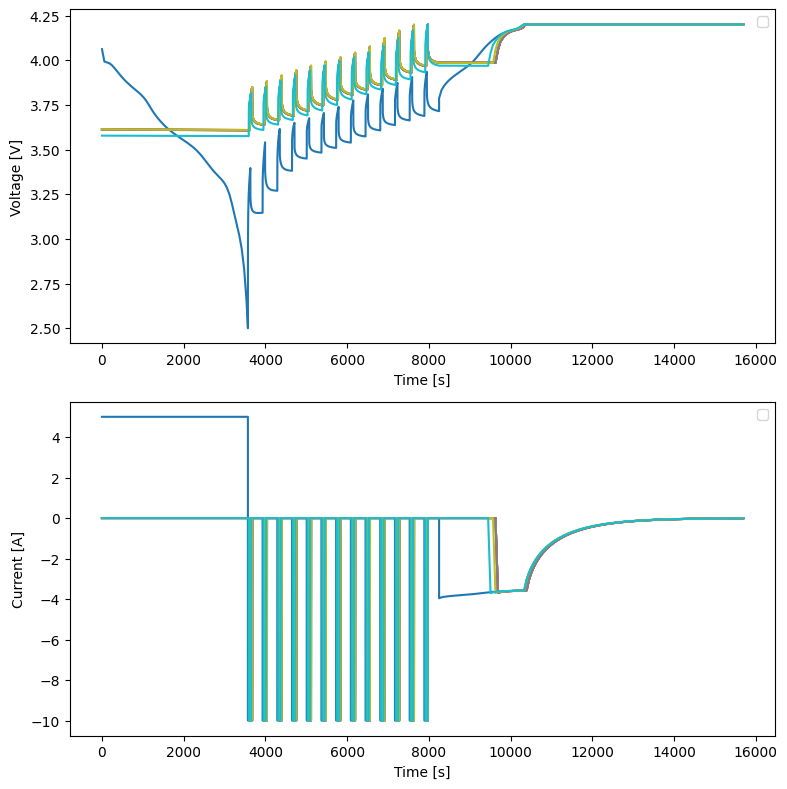

In [10]:
num_entries, solution = fast(rg-1, [])
plot_given_range(solution, 0, rg, num_entries)


In [27]:
_, solution = fast(n-rg, solution)


2023-06-26 18:24:47.026 - [NOTICE] logger.func(15): Cycle 10/10 (99.500 us elapsed) --------------------
2023-06-26 18:24:47.027 - [NOTICE] logger.func(15): Cycle 10/10, step 1/1: Discharge at 5A until 2.5V
2023-06-26 18:24:47.419 - [NOTICE] logger.func(15): Finish experiment simulation, took 393.854 ms
2023-06-26 18:24:48.092 - [NOTICE] logger.func(15): Cycle 11/11 (840.600 us elapsed) --------------------
2023-06-26 18:24:48.096 - [NOTICE] logger.func(15): Cycle 11/11, step 1/2: Charge at 5 C for 1 minute or until 4.2 V
2023-06-26 18:24:48.239 - [NOTICE] logger.func(15): Cycle 11/11, step 2/2: Rest for 5 minutes
2023-06-26 18:24:48.687 - [NOTICE] logger.func(15): Finish experiment simulation, took 594.776 ms
2023-06-26 18:24:48.737 - [NOTICE] logger.func(15): Cycle 12/12 (82.000 us elapsed) --------------------
2023-06-26 18:24:48.738 - [NOTICE] logger.func(15): Cycle 12/12, step 1/2: Charge at 5 C for 1 minute or until 4.2 V
2023-06-26 18:24:48.747 - [NOTICE] logger.func(15): Cycle 

360.0


2023-06-26 18:24:49.923 - [NOTICE] logger.func(15): Finish experiment simulation, took 1.186 s
2023-06-26 18:24:49.986 - [NOTICE] logger.func(15): Cycle 13/13 (127.700 us elapsed) --------------------
2023-06-26 18:24:49.987 - [NOTICE] logger.func(15): Cycle 13/13, step 1/2: Charge at 5 C for 1 minute or until 4.2 V
2023-06-26 18:24:49.993 - [NOTICE] logger.func(15): Cycle 13/13, step 2/2: Rest for 5 minutes


360.0


2023-06-26 18:24:50.370 - [NOTICE] logger.func(15): Finish experiment simulation, took 384.555 ms
2023-06-26 18:24:50.449 - [NOTICE] logger.func(15): Cycle 14/14 (81.800 us elapsed) --------------------
2023-06-26 18:24:50.450 - [NOTICE] logger.func(15): Cycle 14/14, step 1/2: Charge at 5 C for 1 minute or until 4.2 V
2023-06-26 18:24:50.463 - [NOTICE] logger.func(15): Cycle 14/14, step 2/2: Rest for 5 minutes


360.0


2023-06-26 18:24:50.770 - [NOTICE] logger.func(15): Finish experiment simulation, took 320.255 ms
2023-06-26 18:24:50.859 - [NOTICE] logger.func(15): Cycle 15/15 (111.100 us elapsed) --------------------
2023-06-26 18:24:50.862 - [NOTICE] logger.func(15): Cycle 15/15, step 1/2: Charge at 5 C for 1 minute or until 4.2 V
2023-06-26 18:24:50.877 - [NOTICE] logger.func(15): Cycle 15/15, step 2/2: Rest for 5 minutes


360.0


2023-06-26 18:24:51.143 - [NOTICE] logger.func(15): Finish experiment simulation, took 284.899 ms
2023-06-26 18:24:51.238 - [NOTICE] logger.func(15): Cycle 16/16 (323.200 us elapsed) --------------------
2023-06-26 18:24:51.239 - [NOTICE] logger.func(15): Cycle 16/16, step 1/2: Charge at 5 C for 1 minute or until 4.2 V
2023-06-26 18:24:51.254 - [NOTICE] logger.func(15): Cycle 16/16, step 2/2: Rest for 5 minutes


360.0


2023-06-26 18:24:51.567 - [NOTICE] logger.func(15): Finish experiment simulation, took 329.318 ms
2023-06-26 18:24:51.738 - [NOTICE] logger.func(15): Cycle 17/17 (153.300 us elapsed) --------------------
2023-06-26 18:24:51.739 - [NOTICE] logger.func(15): Cycle 17/17, step 1/2: Charge at 5 C for 1 minute or until 4.2 V
2023-06-26 18:24:51.772 - [NOTICE] logger.func(15): Cycle 17/17, step 2/2: Rest for 5 minutes


360.0


2023-06-26 18:24:52.059 - [NOTICE] logger.func(15): Finish experiment simulation, took 320.144 ms


340.68777754862094


2023-06-26 18:24:52.621 - [NOTICE] logger.func(15): Cycle 18/18 (105.300 us elapsed) --------------------
2023-06-26 18:24:52.622 - [NOTICE] logger.func(15): Cycle 18/18, step 1/2: Charge at 15W until 4.2V
2023-06-26 18:24:52.743 - [NOTICE] logger.func(15): Cycle 18/18, step 2/2: Hold at 4.2V until 0.01A
2023-06-26 18:24:53.269 - [NOTICE] logger.func(15): Finish experiment simulation, took 648.314 ms
2023-06-26 18:24:53.271 - [NOTICE] logger.func(15): Cycle 19/19 (172.200 us elapsed) --------------------
2023-06-26 18:24:53.272 - [NOTICE] logger.func(15): Cycle 19/19, step 1/1: Discharge at 5A until 2.5V
2023-06-26 18:24:53.748 - [NOTICE] logger.func(15): Finish experiment simulation, took 474.125 ms
2023-06-26 18:24:53.842 - [NOTICE] logger.func(15): Cycle 20/20 (73.600 us elapsed) --------------------
2023-06-26 18:24:53.844 - [NOTICE] logger.func(15): Cycle 20/20, step 1/2: Charge at 5 C for 1 minute or until 4.2 V
2023-06-26 18:24:53.849 - [NOTICE] logger.func(15): Cycle 20/20, ste

360.0


2023-06-26 18:24:54.560 - [NOTICE] logger.func(15): Finish experiment simulation, took 310.687 ms
2023-06-26 18:24:54.683 - [NOTICE] logger.func(15): Cycle 22/22 (1.125 ms elapsed) --------------------
2023-06-26 18:24:54.685 - [NOTICE] logger.func(15): Cycle 22/22, step 1/2: Charge at 5 C for 1 minute or until 4.2 V
2023-06-26 18:24:54.692 - [NOTICE] logger.func(15): Cycle 22/22, step 2/2: Rest for 5 minutes


360.0


2023-06-26 18:24:55.017 - [NOTICE] logger.func(15): Finish experiment simulation, took 333.618 ms
2023-06-26 18:24:55.124 - [NOTICE] logger.func(15): Cycle 23/23 (149.400 us elapsed) --------------------
2023-06-26 18:24:55.124 - [NOTICE] logger.func(15): Cycle 23/23, step 1/2: Charge at 5 C for 1 minute or until 4.2 V
2023-06-26 18:24:55.132 - [NOTICE] logger.func(15): Cycle 23/23, step 2/2: Rest for 5 minutes


360.0


2023-06-26 18:24:55.391 - [NOTICE] logger.func(15): Finish experiment simulation, took 266.595 ms
2023-06-26 18:24:55.480 - [NOTICE] logger.func(15): Cycle 24/24 (72.900 us elapsed) --------------------
2023-06-26 18:24:55.480 - [NOTICE] logger.func(15): Cycle 24/24, step 1/2: Charge at 5 C for 1 minute or until 4.2 V
2023-06-26 18:24:55.486 - [NOTICE] logger.func(15): Cycle 24/24, step 2/2: Rest for 5 minutes


360.0


2023-06-26 18:24:55.730 - [NOTICE] logger.func(15): Finish experiment simulation, took 250.039 ms
2023-06-26 18:24:55.832 - [NOTICE] logger.func(15): Cycle 25/25 (86.600 us elapsed) --------------------
2023-06-26 18:24:55.833 - [NOTICE] logger.func(15): Cycle 25/25, step 1/2: Charge at 5 C for 1 minute or until 4.2 V
2023-06-26 18:24:55.841 - [NOTICE] logger.func(15): Cycle 25/25, step 2/2: Rest for 5 minutes


360.0


2023-06-26 18:24:56.097 - [NOTICE] logger.func(15): Finish experiment simulation, took 264.637 ms
2023-06-26 18:24:56.192 - [NOTICE] logger.func(15): Cycle 26/26 (70.700 us elapsed) --------------------
2023-06-26 18:24:56.194 - [NOTICE] logger.func(15): Cycle 26/26, step 1/2: Charge at 5 C for 1 minute or until 4.2 V
2023-06-26 18:24:56.203 - [NOTICE] logger.func(15): Cycle 26/26, step 2/2: Rest for 5 minutes


360.0


2023-06-26 18:24:56.458 - [NOTICE] logger.func(15): Finish experiment simulation, took 264.292 ms
2023-06-26 18:24:56.590 - [NOTICE] logger.func(15): Cycle 27/27 (97.600 us elapsed) --------------------
2023-06-26 18:24:56.590 - [NOTICE] logger.func(15): Cycle 27/27, step 1/2: Charge at 15W until 4.2V
2023-06-26 18:24:56.609 - [NOTICE] logger.func(15): Cycle 27/27, step 2/2: Hold at 4.2V until 0.01A


340.22938109352253


2023-06-26 18:24:56.864 - [NOTICE] logger.func(15): Finish experiment simulation, took 272.991 ms
2023-06-26 18:24:56.865 - [NOTICE] logger.func(15): Cycle 28/28 (125.200 us elapsed) --------------------
2023-06-26 18:24:56.865 - [NOTICE] logger.func(15): Cycle 28/28, step 1/1: Discharge at 5A until 2.5V
2023-06-26 18:24:57.115 - [NOTICE] logger.func(15): Finish experiment simulation, took 249.635 ms
2023-06-26 18:24:57.227 - [NOTICE] logger.func(15): Cycle 29/29 (83.900 us elapsed) --------------------
2023-06-26 18:24:57.227 - [NOTICE] logger.func(15): Cycle 29/29, step 1/2: Charge at 5 C for 1 minute or until 4.2 V
2023-06-26 18:24:57.234 - [NOTICE] logger.func(15): Cycle 29/29, step 2/2: Rest for 5 minutes
2023-06-26 18:24:57.677 - [NOTICE] logger.func(15): Finish experiment simulation, took 449.663 ms
2023-06-26 18:24:57.797 - [NOTICE] logger.func(15): Cycle 30/30 (105.300 us elapsed) --------------------
2023-06-26 18:24:57.797 - [NOTICE] logger.func(15): Cycle 30/30, step 1/2: C

360.0


2023-06-26 18:24:58.045 - [NOTICE] logger.func(15): Finish experiment simulation, took 247.789 ms
2023-06-26 18:24:58.173 - [NOTICE] logger.func(15): Cycle 31/31 (123.000 us elapsed) --------------------
2023-06-26 18:24:58.174 - [NOTICE] logger.func(15): Cycle 31/31, step 1/2: Charge at 5 C for 1 minute or until 4.2 V
2023-06-26 18:24:58.179 - [NOTICE] logger.func(15): Cycle 31/31, step 2/2: Rest for 5 minutes


360.0


2023-06-26 18:24:58.418 - [NOTICE] logger.func(15): Finish experiment simulation, took 245.070 ms
2023-06-26 18:24:58.538 - [NOTICE] logger.func(15): Cycle 32/32 (98.800 us elapsed) --------------------
2023-06-26 18:24:58.538 - [NOTICE] logger.func(15): Cycle 32/32, step 1/2: Charge at 5 C for 1 minute or until 4.2 V
2023-06-26 18:24:58.552 - [NOTICE] logger.func(15): Cycle 32/32, step 2/2: Rest for 5 minutes


360.0


2023-06-26 18:24:58.772 - [NOTICE] logger.func(15): Finish experiment simulation, took 233.379 ms
2023-06-26 18:24:58.899 - [NOTICE] logger.func(15): Cycle 33/33 (71.100 us elapsed) --------------------
2023-06-26 18:24:58.899 - [NOTICE] logger.func(15): Cycle 33/33, step 1/2: Charge at 5 C for 1 minute or until 4.2 V
2023-06-26 18:24:58.906 - [NOTICE] logger.func(15): Cycle 33/33, step 2/2: Rest for 5 minutes


360.0


2023-06-26 18:24:59.142 - [NOTICE] logger.func(15): Finish experiment simulation, took 243.701 ms
2023-06-26 18:24:59.273 - [NOTICE] logger.func(15): Cycle 34/34 (70.600 us elapsed) --------------------
2023-06-26 18:24:59.273 - [NOTICE] logger.func(15): Cycle 34/34, step 1/2: Charge at 5 C for 1 minute or until 4.2 V
2023-06-26 18:24:59.280 - [NOTICE] logger.func(15): Cycle 34/34, step 2/2: Rest for 5 minutes


360.0


2023-06-26 18:24:59.504 - [NOTICE] logger.func(15): Finish experiment simulation, took 230.455 ms
2023-06-26 18:24:59.640 - [NOTICE] logger.func(15): Cycle 35/35 (74.000 us elapsed) --------------------
2023-06-26 18:24:59.640 - [NOTICE] logger.func(15): Cycle 35/35, step 1/2: Charge at 5 C for 1 minute or until 4.2 V
2023-06-26 18:24:59.651 - [NOTICE] logger.func(15): Cycle 35/35, step 2/2: Rest for 5 minutes


360.0


2023-06-26 18:24:59.876 - [NOTICE] logger.func(15): Finish experiment simulation, took 235.932 ms
2023-06-26 18:25:00.023 - [NOTICE] logger.func(15): Cycle 36/36 (83.000 us elapsed) --------------------
2023-06-26 18:25:00.025 - [NOTICE] logger.func(15): Cycle 36/36, step 1/2: Charge at 15W until 4.2V
2023-06-26 18:25:00.047 - [NOTICE] logger.func(15): Cycle 36/36, step 2/2: Hold at 4.2V until 0.01A


339.77455088018905


2023-06-26 18:25:00.310 - [NOTICE] logger.func(15): Finish experiment simulation, took 285.757 ms
2023-06-26 18:25:00.311 - [NOTICE] logger.func(15): Cycle 37/37 (69.700 us elapsed) --------------------
2023-06-26 18:25:00.312 - [NOTICE] logger.func(15): Cycle 37/37, step 1/1: Discharge at 5A until 2.5V
2023-06-26 18:25:00.536 - [NOTICE] logger.func(15): Finish experiment simulation, took 223.502 ms
2023-06-26 18:25:00.681 - [NOTICE] logger.func(15): Cycle 38/38 (85.300 us elapsed) --------------------
2023-06-26 18:25:00.681 - [NOTICE] logger.func(15): Cycle 38/38, step 1/2: Charge at 5 C for 1 minute or until 4.2 V
2023-06-26 18:25:00.688 - [NOTICE] logger.func(15): Cycle 38/38, step 2/2: Rest for 5 minutes
2023-06-26 18:25:00.929 - [NOTICE] logger.func(15): Finish experiment simulation, took 246.895 ms
2023-06-26 18:25:01.078 - [NOTICE] logger.func(15): Cycle 39/39 (69.400 us elapsed) --------------------
2023-06-26 18:25:01.079 - [NOTICE] logger.func(15): Cycle 39/39, step 1/2: Cha

360.0


2023-06-26 18:25:01.333 - [NOTICE] logger.func(15): Finish experiment simulation, took 254.476 ms
2023-06-26 18:25:01.484 - [NOTICE] logger.func(15): Cycle 40/40 (84.500 us elapsed) --------------------
2023-06-26 18:25:01.485 - [NOTICE] logger.func(15): Cycle 40/40, step 1/2: Charge at 5 C for 1 minute or until 4.2 V
2023-06-26 18:25:01.491 - [NOTICE] logger.func(15): Cycle 40/40, step 2/2: Rest for 5 minutes


360.0


2023-06-26 18:25:01.735 - [NOTICE] logger.func(15): Finish experiment simulation, took 250.325 ms
2023-06-26 18:25:01.902 - [NOTICE] logger.func(15): Cycle 41/41 (82.500 us elapsed) --------------------
2023-06-26 18:25:01.902 - [NOTICE] logger.func(15): Cycle 41/41, step 1/2: Charge at 5 C for 1 minute or until 4.2 V
2023-06-26 18:25:01.910 - [NOTICE] logger.func(15): Cycle 41/41, step 2/2: Rest for 5 minutes


360.0


2023-06-26 18:25:02.414 - [NOTICE] logger.func(15): Finish experiment simulation, took 511.100 ms
2023-06-26 18:25:02.582 - [NOTICE] logger.func(15): Cycle 42/42 (70.600 us elapsed) --------------------
2023-06-26 18:25:02.582 - [NOTICE] logger.func(15): Cycle 42/42, step 1/2: Charge at 5 C for 1 minute or until 4.2 V
2023-06-26 18:25:02.589 - [NOTICE] logger.func(15): Cycle 42/42, step 2/2: Rest for 5 minutes


360.0


2023-06-26 18:25:02.808 - [NOTICE] logger.func(15): Finish experiment simulation, took 226.313 ms
2023-06-26 18:25:02.978 - [NOTICE] logger.func(15): Cycle 43/43 (74.200 us elapsed) --------------------
2023-06-26 18:25:02.978 - [NOTICE] logger.func(15): Cycle 43/43, step 1/2: Charge at 5 C for 1 minute or until 4.2 V
2023-06-26 18:25:02.984 - [NOTICE] logger.func(15): Cycle 43/43, step 2/2: Rest for 5 minutes


360.0


2023-06-26 18:25:03.202 - [NOTICE] logger.func(15): Finish experiment simulation, took 222.937 ms
2023-06-26 18:25:03.373 - [NOTICE] logger.func(15): Cycle 44/44 (75.200 us elapsed) --------------------
2023-06-26 18:25:03.373 - [NOTICE] logger.func(15): Cycle 44/44, step 1/2: Charge at 5 C for 1 minute or until 4.2 V
2023-06-26 18:25:03.381 - [NOTICE] logger.func(15): Cycle 44/44, step 2/2: Rest for 5 minutes


360.0


2023-06-26 18:25:03.644 - [NOTICE] logger.func(15): Finish experiment simulation, took 271.043 ms
2023-06-26 18:25:03.812 - [NOTICE] logger.func(15): Cycle 45/45 (153.300 us elapsed) --------------------
2023-06-26 18:25:03.812 - [NOTICE] logger.func(15): Cycle 45/45, step 1/2: Charge at 15W until 4.2V
2023-06-26 18:25:03.830 - [NOTICE] logger.func(15): Cycle 45/45, step 2/2: Hold at 4.2V until 0.01A


339.322720563061


2023-06-26 18:25:04.247 - [NOTICE] logger.func(15): Finish experiment simulation, took 432.145 ms
2023-06-26 18:25:04.250 - [NOTICE] logger.func(15): Cycle 46/46 (176.400 us elapsed) --------------------
2023-06-26 18:25:04.251 - [NOTICE] logger.func(15): Cycle 46/46, step 1/1: Discharge at 5A until 2.5V
2023-06-26 18:25:04.586 - [NOTICE] logger.func(15): Finish experiment simulation, took 330.649 ms
2023-06-26 18:25:04.907 - [NOTICE] logger.func(15): Cycle 47/47 (167.000 us elapsed) --------------------
2023-06-26 18:25:04.910 - [NOTICE] logger.func(15): Cycle 47/47, step 1/2: Charge at 5 C for 1 minute or until 4.2 V
2023-06-26 18:25:04.943 - [NOTICE] logger.func(15): Cycle 47/47, step 2/2: Rest for 5 minutes
2023-06-26 18:25:05.330 - [NOTICE] logger.func(15): Finish experiment simulation, took 421.664 ms
2023-06-26 18:25:05.529 - [NOTICE] logger.func(15): Cycle 48/48 (71.500 us elapsed) --------------------
2023-06-26 18:25:05.529 - [NOTICE] logger.func(15): Cycle 48/48, step 1/2: C

360.0


2023-06-26 18:25:05.828 - [NOTICE] logger.func(15): Finish experiment simulation, took 299.085 ms
2023-06-26 18:25:06.036 - [NOTICE] logger.func(15): Cycle 49/49 (67.600 us elapsed) --------------------
2023-06-26 18:25:06.037 - [NOTICE] logger.func(15): Cycle 49/49, step 1/2: Charge at 5 C for 1 minute or until 4.2 V
2023-06-26 18:25:06.042 - [NOTICE] logger.func(15): Cycle 49/49, step 2/2: Rest for 5 minutes


360.0


2023-06-26 18:25:06.288 - [NOTICE] logger.func(15): Finish experiment simulation, took 250.770 ms
2023-06-26 18:25:06.549 - [NOTICE] logger.func(15): Cycle 50/50 (205.600 us elapsed) --------------------
2023-06-26 18:25:06.550 - [NOTICE] logger.func(15): Cycle 50/50, step 1/2: Charge at 5 C for 1 minute or until 4.2 V
2023-06-26 18:25:06.556 - [NOTICE] logger.func(15): Cycle 50/50, step 2/2: Rest for 5 minutes


360.0


2023-06-26 18:25:06.939 - [NOTICE] logger.func(15): Finish experiment simulation, took 389.165 ms
2023-06-26 18:25:07.160 - [NOTICE] logger.func(15): Cycle 51/51 (198.500 us elapsed) --------------------
2023-06-26 18:25:07.165 - [NOTICE] logger.func(15): Cycle 51/51, step 1/2: Charge at 5 C for 1 minute or until 4.2 V
2023-06-26 18:25:07.192 - [NOTICE] logger.func(15): Cycle 51/51, step 2/2: Rest for 5 minutes


360.0


2023-06-26 18:25:07.528 - [NOTICE] logger.func(15): Finish experiment simulation, took 362.718 ms
2023-06-26 18:25:07.772 - [NOTICE] logger.func(15): Cycle 52/52 (181.400 us elapsed) --------------------
2023-06-26 18:25:07.776 - [NOTICE] logger.func(15): Cycle 52/52, step 1/2: Charge at 5 C for 1 minute or until 4.2 V
2023-06-26 18:25:07.791 - [NOTICE] logger.func(15): Cycle 52/52, step 2/2: Rest for 5 minutes


360.0


2023-06-26 18:25:08.127 - [NOTICE] logger.func(15): Finish experiment simulation, took 353.711 ms
2023-06-26 18:25:08.396 - [NOTICE] logger.func(15): Cycle 53/53 (71.500 us elapsed) --------------------
2023-06-26 18:25:08.396 - [NOTICE] logger.func(15): Cycle 53/53, step 1/2: Charge at 5 C for 1 minute or until 4.2 V
2023-06-26 18:25:08.428 - [NOTICE] logger.func(15): Cycle 53/53, step 2/2: Rest for 5 minutes


360.0


2023-06-26 18:25:08.777 - [NOTICE] logger.func(15): Finish experiment simulation, took 380.128 ms
2023-06-26 18:25:09.021 - [NOTICE] logger.func(15): Cycle 54/54 (70.800 us elapsed) --------------------
2023-06-26 18:25:09.022 - [NOTICE] logger.func(15): Cycle 54/54, step 1/2: Charge at 15W until 4.2V
2023-06-26 18:25:09.060 - [NOTICE] logger.func(15): Cycle 54/54, step 2/2: Hold at 4.2V until 0.01A


338.8740663725621


2023-06-26 18:25:09.413 - [NOTICE] logger.func(15): Finish experiment simulation, took 389.707 ms
2023-06-26 18:25:09.415 - [NOTICE] logger.func(15): Cycle 55/55 (206.200 us elapsed) --------------------
2023-06-26 18:25:09.416 - [NOTICE] logger.func(15): Cycle 55/55, step 1/1: Discharge at 5A until 2.5V
2023-06-26 18:25:09.713 - [NOTICE] logger.func(15): Finish experiment simulation, took 296.993 ms
2023-06-26 18:25:09.956 - [NOTICE] logger.func(15): Cycle 56/56 (93.900 us elapsed) --------------------
2023-06-26 18:25:09.956 - [NOTICE] logger.func(15): Cycle 56/56, step 1/2: Charge at 5 C for 1 minute or until 4.2 V
2023-06-26 18:25:09.963 - [NOTICE] logger.func(15): Cycle 56/56, step 2/2: Rest for 5 minutes
2023-06-26 18:25:10.556 - [NOTICE] logger.func(15): Finish experiment simulation, took 598.010 ms
2023-06-26 18:25:10.788 - [NOTICE] logger.func(15): Cycle 57/57 (90.400 us elapsed) --------------------
2023-06-26 18:25:10.788 - [NOTICE] logger.func(15): Cycle 57/57, step 1/2: Ch

360.0


2023-06-26 18:25:11.032 - [NOTICE] logger.func(15): Finish experiment simulation, took 243.863 ms
2023-06-26 18:25:11.338 - [NOTICE] logger.func(15): Cycle 58/58 (268.300 us elapsed) --------------------
2023-06-26 18:25:11.339 - [NOTICE] logger.func(15): Cycle 58/58, step 1/2: Charge at 5 C for 1 minute or until 4.2 V
2023-06-26 18:25:11.345 - [NOTICE] logger.func(15): Cycle 58/58, step 2/2: Rest for 5 minutes


360.0


2023-06-26 18:25:11.721 - [NOTICE] logger.func(15): Finish experiment simulation, took 381.416 ms
2023-06-26 18:25:11.958 - [NOTICE] logger.func(15): Cycle 59/59 (96.100 us elapsed) --------------------
2023-06-26 18:25:11.958 - [NOTICE] logger.func(15): Cycle 59/59, step 1/2: Charge at 5 C for 1 minute or until 4.2 V
2023-06-26 18:25:11.970 - [NOTICE] logger.func(15): Cycle 59/59, step 2/2: Rest for 5 minutes


360.0


2023-06-26 18:25:12.307 - [NOTICE] logger.func(15): Finish experiment simulation, took 348.101 ms
2023-06-26 18:25:12.578 - [NOTICE] logger.func(15): Cycle 60/60 (68.800 us elapsed) --------------------
2023-06-26 18:25:12.579 - [NOTICE] logger.func(15): Cycle 60/60, step 1/2: Charge at 5 C for 1 minute or until 4.2 V
2023-06-26 18:25:12.585 - [NOTICE] logger.func(15): Cycle 60/60, step 2/2: Rest for 5 minutes


360.0


2023-06-26 18:25:12.847 - [NOTICE] logger.func(15): Finish experiment simulation, took 267.702 ms
2023-06-26 18:25:13.107 - [NOTICE] logger.func(15): Cycle 61/61 (76.000 us elapsed) --------------------
2023-06-26 18:25:13.108 - [NOTICE] logger.func(15): Cycle 61/61, step 1/2: Charge at 5 C for 1 minute or until 4.2 V
2023-06-26 18:25:13.113 - [NOTICE] logger.func(15): Cycle 61/61, step 2/2: Rest for 5 minutes


360.0


2023-06-26 18:25:13.364 - [NOTICE] logger.func(15): Finish experiment simulation, took 255.090 ms
2023-06-26 18:25:13.640 - [NOTICE] logger.func(15): Cycle 62/62 (80.400 us elapsed) --------------------
2023-06-26 18:25:13.641 - [NOTICE] logger.func(15): Cycle 62/62, step 1/2: Charge at 5 C for 1 minute or until 4.2 V
2023-06-26 18:25:13.652 - [NOTICE] logger.func(15): Cycle 62/62, step 2/2: Rest for 5 minutes


360.0


2023-06-26 18:25:13.982 - [NOTICE] logger.func(15): Finish experiment simulation, took 340.106 ms
2023-06-26 18:25:14.256 - [NOTICE] logger.func(15): Cycle 63/63 (154.200 us elapsed) --------------------
2023-06-26 18:25:14.257 - [NOTICE] logger.func(15): Cycle 63/63, step 1/2: Charge at 15W until 4.2V
2023-06-26 18:25:14.301 - [NOTICE] logger.func(15): Cycle 63/63, step 2/2: Hold at 4.2V until 0.01A


338.42820607640897


2023-06-26 18:25:14.673 - [NOTICE] logger.func(15): Finish experiment simulation, took 415.499 ms
2023-06-26 18:25:14.677 - [NOTICE] logger.func(15): Cycle 64/64 (413.700 us elapsed) --------------------
2023-06-26 18:25:14.678 - [NOTICE] logger.func(15): Cycle 64/64, step 1/1: Discharge at 5A until 2.5V
2023-06-26 18:25:15.045 - [NOTICE] logger.func(15): Finish experiment simulation, took 362.382 ms
2023-06-26 18:25:15.466 - [NOTICE] logger.func(15): Cycle 65/65 (367.200 us elapsed) --------------------
2023-06-26 18:25:15.468 - [NOTICE] logger.func(15): Cycle 65/65, step 1/2: Charge at 5 C for 1 minute or until 4.2 V
2023-06-26 18:25:15.482 - [NOTICE] logger.func(15): Cycle 65/65, step 2/2: Rest for 5 minutes
2023-06-26 18:25:15.869 - [NOTICE] logger.func(15): Finish experiment simulation, took 402.011 ms
2023-06-26 18:25:16.200 - [NOTICE] logger.func(15): Cycle 66/66 (78.500 us elapsed) --------------------
2023-06-26 18:25:16.200 - [NOTICE] logger.func(15): Cycle 66/66, step 1/2: C

360.0


2023-06-26 18:25:16.573 - [NOTICE] logger.func(15): Finish experiment simulation, took 371.669 ms
2023-06-26 18:25:16.863 - [NOTICE] logger.func(15): Cycle 67/67 (76.600 us elapsed) --------------------
2023-06-26 18:25:16.863 - [NOTICE] logger.func(15): Cycle 67/67, step 1/2: Charge at 5 C for 1 minute or until 4.2 V
2023-06-26 18:25:16.867 - [NOTICE] logger.func(15): Cycle 67/67, step 2/2: Rest for 5 minutes


360.0


2023-06-26 18:25:17.171 - [NOTICE] logger.func(15): Finish experiment simulation, took 295.238 ms
2023-06-26 18:25:17.533 - [NOTICE] logger.func(15): Cycle 68/68 (79.700 us elapsed) --------------------
2023-06-26 18:25:17.534 - [NOTICE] logger.func(15): Cycle 68/68, step 1/2: Charge at 5 C for 1 minute or until 4.2 V
2023-06-26 18:25:17.543 - [NOTICE] logger.func(15): Cycle 68/68, step 2/2: Rest for 5 minutes


360.0


2023-06-26 18:25:17.865 - [NOTICE] logger.func(15): Finish experiment simulation, took 328.278 ms
2023-06-26 18:25:18.260 - [NOTICE] logger.func(15): Cycle 69/69 (301.900 us elapsed) --------------------
2023-06-26 18:25:18.261 - [NOTICE] logger.func(15): Cycle 69/69, step 1/2: Charge at 5 C for 1 minute or until 4.2 V
2023-06-26 18:25:18.271 - [NOTICE] logger.func(15): Cycle 69/69, step 2/2: Rest for 5 minutes


360.0


2023-06-26 18:25:18.650 - [NOTICE] logger.func(15): Finish experiment simulation, took 383.921 ms
2023-06-26 18:25:19.017 - [NOTICE] logger.func(15): Cycle 70/70 (152.700 us elapsed) --------------------
2023-06-26 18:25:19.019 - [NOTICE] logger.func(15): Cycle 70/70, step 1/2: Charge at 5 C for 1 minute or until 4.2 V
2023-06-26 18:25:19.032 - [NOTICE] logger.func(15): Cycle 70/70, step 2/2: Rest for 5 minutes


360.0


2023-06-26 18:25:19.342 - [NOTICE] logger.func(15): Finish experiment simulation, took 323.841 ms
2023-06-26 18:25:19.714 - [NOTICE] logger.func(15): Cycle 71/71 (93.600 us elapsed) --------------------
2023-06-26 18:25:19.715 - [NOTICE] logger.func(15): Cycle 71/71, step 1/2: Charge at 5 C for 1 minute or until 4.2 V
2023-06-26 18:25:19.725 - [NOTICE] logger.func(15): Cycle 71/71, step 2/2: Rest for 5 minutes


360.0


2023-06-26 18:25:20.028 - [NOTICE] logger.func(15): Finish experiment simulation, took 311.434 ms
2023-06-26 18:25:20.411 - [NOTICE] logger.func(15): Cycle 72/72 (75.900 us elapsed) --------------------
2023-06-26 18:25:20.411 - [NOTICE] logger.func(15): Cycle 72/72, step 1/2: Charge at 15W until 4.2V
2023-06-26 18:25:20.430 - [NOTICE] logger.func(15): Cycle 72/72, step 2/2: Hold at 4.2V until 0.01A


337.9852562610031


2023-06-26 18:25:21.034 - [NOTICE] logger.func(15): Finish experiment simulation, took 622.494 ms
2023-06-26 18:25:21.036 - [NOTICE] logger.func(15): Cycle 73/73 (71.800 us elapsed) --------------------
2023-06-26 18:25:21.036 - [NOTICE] logger.func(15): Cycle 73/73, step 1/1: Discharge at 5A until 2.5V
2023-06-26 18:25:21.269 - [NOTICE] logger.func(15): Finish experiment simulation, took 232.103 ms
2023-06-26 18:25:21.550 - [NOTICE] logger.func(15): Cycle 74/74 (116.000 us elapsed) --------------------
2023-06-26 18:25:21.551 - [NOTICE] logger.func(15): Cycle 74/74, step 1/2: Charge at 5 C for 1 minute or until 4.2 V
2023-06-26 18:25:21.557 - [NOTICE] logger.func(15): Cycle 74/74, step 2/2: Rest for 5 minutes
2023-06-26 18:25:21.797 - [NOTICE] logger.func(15): Finish experiment simulation, took 246.800 ms
2023-06-26 18:25:22.079 - [NOTICE] logger.func(15): Cycle 75/75 (121.900 us elapsed) --------------------
2023-06-26 18:25:22.080 - [NOTICE] logger.func(15): Cycle 75/75, step 1/2: C

360.0


2023-06-26 18:25:22.325 - [NOTICE] logger.func(15): Finish experiment simulation, took 243.959 ms
2023-06-26 18:25:22.617 - [NOTICE] logger.func(15): Cycle 76/76 (78.200 us elapsed) --------------------
2023-06-26 18:25:22.618 - [NOTICE] logger.func(15): Cycle 76/76, step 1/2: Charge at 5 C for 1 minute or until 4.2 V
2023-06-26 18:25:22.625 - [NOTICE] logger.func(15): Cycle 76/76, step 2/2: Rest for 5 minutes


360.0


2023-06-26 18:25:22.862 - [NOTICE] logger.func(15): Finish experiment simulation, took 243.355 ms
2023-06-26 18:25:23.183 - [NOTICE] logger.func(15): Cycle 77/77 (80.000 us elapsed) --------------------
2023-06-26 18:25:23.184 - [NOTICE] logger.func(15): Cycle 77/77, step 1/2: Charge at 5 C for 1 minute or until 4.2 V
2023-06-26 18:25:23.191 - [NOTICE] logger.func(15): Cycle 77/77, step 2/2: Rest for 5 minutes


360.0


2023-06-26 18:25:23.422 - [NOTICE] logger.func(15): Finish experiment simulation, took 237.885 ms
2023-06-26 18:25:23.714 - [NOTICE] logger.func(15): Cycle 78/78 (80.000 us elapsed) --------------------
2023-06-26 18:25:23.714 - [NOTICE] logger.func(15): Cycle 78/78, step 1/2: Charge at 5 C for 1 minute or until 4.2 V
2023-06-26 18:25:23.720 - [NOTICE] logger.func(15): Cycle 78/78, step 2/2: Rest for 5 minutes


360.0


2023-06-26 18:25:23.971 - [NOTICE] logger.func(15): Finish experiment simulation, took 256.697 ms
2023-06-26 18:25:24.279 - [NOTICE] logger.func(15): Cycle 79/79 (76.600 us elapsed) --------------------
2023-06-26 18:25:24.279 - [NOTICE] logger.func(15): Cycle 79/79, step 1/2: Charge at 5 C for 1 minute or until 4.2 V
2023-06-26 18:25:24.285 - [NOTICE] logger.func(15): Cycle 79/79, step 2/2: Rest for 5 minutes


360.0


2023-06-26 18:25:24.521 - [NOTICE] logger.func(15): Finish experiment simulation, took 240.491 ms
2023-06-26 18:25:24.920 - [NOTICE] logger.func(15): Cycle 80/80 (437.000 us elapsed) --------------------
2023-06-26 18:25:24.921 - [NOTICE] logger.func(15): Cycle 80/80, step 1/2: Charge at 5 C for 1 minute or until 4.2 V
2023-06-26 18:25:24.944 - [NOTICE] logger.func(15): Cycle 80/80, step 2/2: Rest for 5 minutes


360.0


2023-06-26 18:25:25.219 - [NOTICE] logger.func(15): Finish experiment simulation, took 297.593 ms
2023-06-26 18:25:25.635 - [NOTICE] logger.func(15): Cycle 81/81 (101.900 us elapsed) --------------------
2023-06-26 18:25:25.636 - [NOTICE] logger.func(15): Cycle 81/81, step 1/2: Charge at 15W until 4.2V
2023-06-26 18:25:25.669 - [NOTICE] logger.func(15): Cycle 81/81, step 2/2: Hold at 4.2V until 0.01A


337.54493580388953


2023-06-26 18:25:26.042 - [NOTICE] logger.func(15): Finish experiment simulation, took 406.195 ms
2023-06-26 18:25:26.043 - [NOTICE] logger.func(15): Cycle 82/82 (80.000 us elapsed) --------------------
2023-06-26 18:25:26.043 - [NOTICE] logger.func(15): Cycle 82/82, step 1/1: Discharge at 5A until 2.5V
2023-06-26 18:25:26.388 - [NOTICE] logger.func(15): Finish experiment simulation, took 343.767 ms
2023-06-26 18:25:26.715 - [NOTICE] logger.func(15): Cycle 83/83 (110.700 us elapsed) --------------------
2023-06-26 18:25:26.716 - [NOTICE] logger.func(15): Cycle 83/83, step 1/2: Charge at 5 C for 1 minute or until 4.2 V
2023-06-26 18:25:26.722 - [NOTICE] logger.func(15): Cycle 83/83, step 2/2: Rest for 5 minutes
2023-06-26 18:25:26.980 - [NOTICE] logger.func(15): Finish experiment simulation, took 264.275 ms
2023-06-26 18:25:27.297 - [NOTICE] logger.func(15): Cycle 84/84 (76.700 us elapsed) --------------------
2023-06-26 18:25:27.298 - [NOTICE] logger.func(15): Cycle 84/84, step 1/2: Ch

360.0


2023-06-26 18:25:27.528 - [NOTICE] logger.func(15): Finish experiment simulation, took 229.083 ms
2023-06-26 18:25:27.840 - [NOTICE] logger.func(15): Cycle 85/85 (75.000 us elapsed) --------------------
2023-06-26 18:25:27.840 - [NOTICE] logger.func(15): Cycle 85/85, step 1/2: Charge at 5 C for 1 minute or until 4.2 V
2023-06-26 18:25:27.847 - [NOTICE] logger.func(15): Cycle 85/85, step 2/2: Rest for 5 minutes


360.0


2023-06-26 18:25:28.079 - [NOTICE] logger.func(15): Finish experiment simulation, took 237.444 ms
2023-06-26 18:25:28.402 - [NOTICE] logger.func(15): Cycle 86/86 (77.200 us elapsed) --------------------
2023-06-26 18:25:28.403 - [NOTICE] logger.func(15): Cycle 86/86, step 1/2: Charge at 5 C for 1 minute or until 4.2 V
2023-06-26 18:25:28.408 - [NOTICE] logger.func(15): Cycle 86/86, step 2/2: Rest for 5 minutes


360.0


2023-06-26 18:25:28.624 - [NOTICE] logger.func(15): Finish experiment simulation, took 221.045 ms
2023-06-26 18:25:28.947 - [NOTICE] logger.func(15): Cycle 87/87 (181.800 us elapsed) --------------------
2023-06-26 18:25:28.949 - [NOTICE] logger.func(15): Cycle 87/87, step 1/2: Charge at 5 C for 1 minute or until 4.2 V
2023-06-26 18:25:28.956 - [NOTICE] logger.func(15): Cycle 87/87, step 2/2: Rest for 5 minutes


360.0


2023-06-26 18:25:29.193 - [NOTICE] logger.func(15): Finish experiment simulation, took 244.781 ms
2023-06-26 18:25:29.547 - [NOTICE] logger.func(15): Cycle 88/88 (79.300 us elapsed) --------------------
2023-06-26 18:25:29.548 - [NOTICE] logger.func(15): Cycle 88/88, step 1/2: Charge at 5 C for 1 minute or until 4.2 V
2023-06-26 18:25:29.557 - [NOTICE] logger.func(15): Cycle 88/88, step 2/2: Rest for 5 minutes


360.0


2023-06-26 18:25:29.874 - [NOTICE] logger.func(15): Finish experiment simulation, took 325.609 ms
2023-06-26 18:25:30.256 - [NOTICE] logger.func(15): Cycle 89/89 (75.900 us elapsed) --------------------
2023-06-26 18:25:30.256 - [NOTICE] logger.func(15): Cycle 89/89, step 1/2: Charge at 5 C for 1 minute or until 4.2 V
2023-06-26 18:25:30.268 - [NOTICE] logger.func(15): Cycle 89/89, step 2/2: Rest for 5 minutes


360.0


2023-06-26 18:25:30.559 - [NOTICE] logger.func(15): Finish experiment simulation, took 301.517 ms
2023-06-26 18:25:30.975 - [NOTICE] logger.func(15): Cycle 90/90 (108.200 us elapsed) --------------------
2023-06-26 18:25:30.978 - [NOTICE] logger.func(15): Cycle 90/90, step 1/2: Charge at 15W until 4.2V
2023-06-26 18:25:31.013 - [NOTICE] logger.func(15): Cycle 90/90, step 2/2: Hold at 4.2V until 0.01A


337.1072179569019


2023-06-26 18:25:31.282 - [NOTICE] logger.func(15): Finish experiment simulation, took 306.248 ms


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


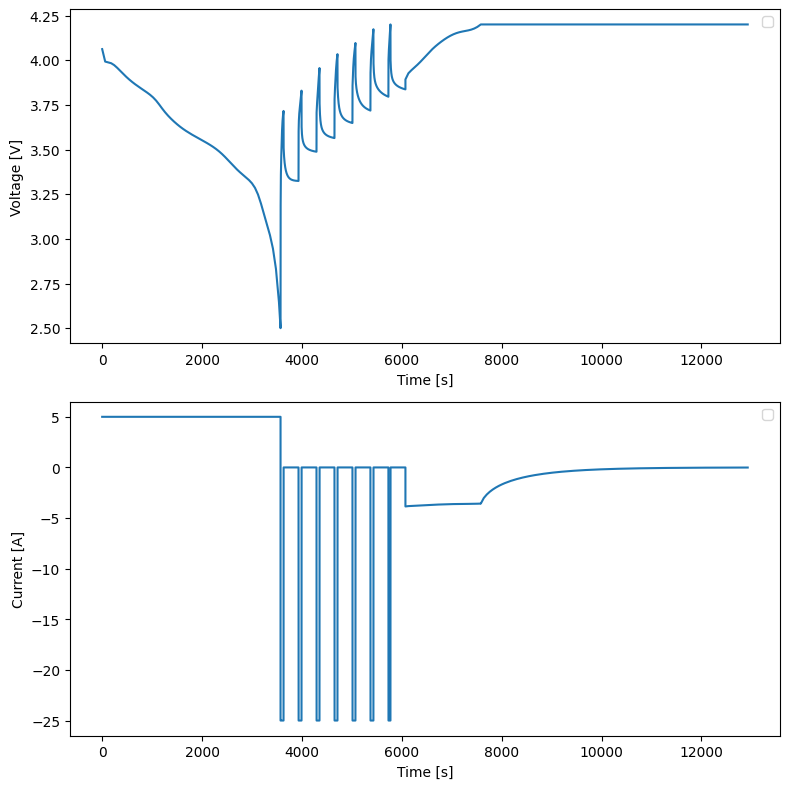

In [29]:
plot_given_range(solution, 0, rg, num_entries)


In [30]:
solution[-1].t[3800:4000]

array([17573.48658221, 17574.48658221, 17575.48658221, 17576.48658221,
       17577.48658221, 17578.48658221, 17579.48658221, 17580.48658221,
       17581.48658221, 17582.48658221, 17583.48658221, 17584.48658221,
       17585.48658221, 17586.48658221, 17587.48658221, 17588.48658221,
       17589.48658221, 17590.48658221, 17591.48658221, 17592.48658221,
       17593.48658221, 17594.48658221, 17595.48658221, 17596.48658221,
       17597.48658221, 17598.48658221, 17599.48658221, 17600.48658221,
       17601.48658221, 17602.48658221, 17603.48658221, 17604.48658221,
       17605.48658221, 17606.48658221, 17607.48658221, 17608.48658221,
       17609.48658221, 17610.48658221, 17611.48658221, 17612.48658221,
       17613.48658221, 17614.48658221, 17615.48658221, 17615.48658221,
       17616.48658221, 17617.48658221, 17618.48658221, 17619.48658221,
       17620.48658221, 17621.48658221, 17622.48658221, 17623.48658221,
       17624.48658221, 17625.48658221, 17626.48658221, 17627.48658221,
      